In [40]:
import cv2
import math
import numpy as np
from itertools import combinations
from ultralytics import YOLO
import math
import cv2
from utils import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Circle, Rectangle
import seaborn as sns
from collections import Counter
import pandas as pd
from datetime import datetime


BACKGROUND_WIDTH = 500
BACKGROUND_HEIGHT = 800

ALIGNED_WIDTH = 300
ALIGNED_HEIGHT = 600
def detect_direction_changes(positions, angle_threshold=45, min_distance=20, min_velocity=10, min_frames_gap=5):
    """
    Phát hiện các chỉ số frame mà bóng đổi hướng mạnh với các cải tiến:
    - angle_threshold: góc (độ) thay đổi vận tốc để coi là đổi hướng
    - min_distance: khoảng cách tối thiểu bóng di chuyển để coi là có ý nghĩa
    - min_velocity: vận tốc tối thiểu để coi là chuyển động thực sự
    - min_frames_gap: khoảng cách tối thiểu giữa các điểm thay đổi hướng
    """
    change_points = []
    # Bỏ qua (-1,-1)
    clean_positions = [(i, p) for i, p in enumerate(positions) if p != (-1, -1)]

    if len(clean_positions) < 3:
        return change_points

    for i in range(2, len(clean_positions)):
        idx1, p1 = clean_positions[i-2]
        idx2, p2 = clean_positions[i-1]
        idx3, p3 = clean_positions[i]

        # Vector vận tốc
        v1 = (p2[0]-p1[0], p2[1]-p1[1])
        v2 = (p3[0]-p2[0], p3[1]-p2[1])

        # Độ dài vector
        len1 = math.hypot(*v1)
        len2 = math.hypot(*v2)
        
        # Kiểm tra vận tốc tối thiểu
        if len1 < min_velocity or len2 < min_velocity:
            continue
            
        # Kiểm tra khoảng cách di chuyển tối thiểu
        dist1 = math.hypot(p2[0]-p1[0], p2[1]-p1[1])
        dist2 = math.hypot(p3[0]-p2[0], p3[1]-p2[1])
        if dist1 < min_distance or dist2 < min_distance:
            continue

        # Tính cos góc
        dot = v1[0]*v2[0] + v1[1]*v2[1]
        cos_theta = max(-1, min(1, dot / (len1 * len2)))
        angle = math.degrees(math.acos(cos_theta))

        # Kiểm tra góc thay đổi
        if angle > angle_threshold:
            # Kiểm tra khoảng cách với điểm thay đổi hướng gần nhất
            if len(change_points) == 0 or idx2 - change_points[-1] >= min_frames_gap:
                change_points.append(idx2)  # đánh dấu điểm giữa (p2)

    return change_points

def detect_direction_changes(positions, angle_threshold=45):
    """
    Phát hiện các chỉ số frame mà bóng đổi hướng mạnh.
    - angle_threshold: góc (độ) thay đổi vận tốc để coi là đổi hướng.
    """
    change_points = []
    # Bỏ qua (-1,-1)
    clean_positions = [(i, p) for i, p in enumerate(positions) if p != (-1, -1)]

    for i in range(2, len(clean_positions)):
        idx1, p1 = clean_positions[i-2]
        idx2, p2 = clean_positions[i-1]
        idx3, p3 = clean_positions[i]

        # Vector vận tốc
        v1 = (p2[0]-p1[0], p2[1]-p1[1])
        v2 = (p3[0]-p2[0], p3[1]-p2[1])

        # Độ dài vector
        len1 = math.hypot(*v1)
        len2 = math.hypot(*v2)
        if len1 == 0 or len2 == 0:
            continue

        # Tính cos góc
        dot = v1[0]*v2[0] + v1[1]*v2[1]
        cos_theta = max(-1, min(1, dot / (len1 * len2)))
        angle = math.degrees(math.acos(cos_theta))

        if angle > angle_threshold:
            change_points.append(idx2)  # đánh dấu điểm giữa (p2)

    return change_points

class BallDetector:
    def __init__(self, model_path, conf=0.7, batch_size=150, person_model_path="yolov8m.pt"):
        self.model = YOLO(model_path)
        self.conf = conf
        self.batch_size = batch_size
        # Load person detection model
        self.person_model = YOLO(person_model_path)

    # --- Bước 1: Đọc video và chia batch ---
    def read_video(self, video_path):
        cap = cv2.VideoCapture(video_path)
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(frame)
        cap.release()
        return frames

    def batch_frames(self, frames):
        return [frames[i:i+self.batch_size] for i in range(0, len(frames), self.batch_size)]

    # --- Bước 2: Dò bóng YOLO ---
    def detect_positions(self, frames):
        batches = self.batch_frames(frames)
        positions = []
        for batch in batches:
            results = self.model.predict(batch, batch=self.batch_size, verbose=False, conf = 0.5)
            for res in results:
                if res.boxes is not None and len(res.boxes) > 0:
                    best_idx = res.boxes.conf.argmax()
                    x, y, w, h = res.boxes.xywh[best_idx].cpu().numpy()
                    positions.append((x, y))
                else:
                    positions.append((-1, -1))
        return positions

    # --- Bước 3: Loại bỏ điểm bất thường trong nhóm ---
    def correct_positions(self, positions):
        corrected_positions = []
        current_group = []

        def process_group(group):
            if len(group) < 2:
                return group
            mean_x = sum(x for x, _ in group) / len(group)
            mean_y = sum(y for _, y in group) / len(group)
            mean_point = (mean_x, mean_y)
            distances = [math.dist(p1, p2) for p1, p2 in combinations(group, 2)]
            avg_dist = sum(distances) / len(distances)
            corrected = []
            for (x, y) in group:
                d = math.dist((x, y), mean_point)
                if d > avg_dist:
                    dx, dy = x - mean_x, y - mean_y
                    length = math.hypot(dx, dy)
                    if length == 0:
                        corrected.append((x, y))
                    else:
                        new_x = mean_x + dx / length * avg_dist
                        new_y = mean_y + dy / length * avg_dist
                        corrected.append((new_x, new_y))
                else:
                    corrected.append((x, y))
            return corrected

        for p in positions:
            if p == (-1, -1):
                if current_group:
                    corrected_positions.extend(process_group(current_group))
                    current_group = []
                corrected_positions.append(p)
            else:
                current_group.append(p)

        if current_group:
            corrected_positions.extend(process_group(current_group))
        return corrected_positions

    # --- Bước 4: Làm mượt bằng khoảng cách trung bình động ---
    def smooth_positions(self, positions, threshold_factor=2.5):
        clean_positions = []
        avg_dist = None
        pending = []

        def dist(a, b): return math.dist(a, b)

        for p in positions:
            if p == (-1, -1):
                clean_positions.append(p)
                continue

            if not clean_positions or clean_positions[-1] == (-1, -1):
                clean_positions.append(p)
                continue

            last_valid = clean_positions[-1]
            d = dist(last_valid, p)

            if avg_dist is None:
                avg_dist = d
            else:
                avg_dist = avg_dist * 0.9 + d * 0.1

            if d > threshold_factor * avg_dist:
                pending.append((len(clean_positions), p))
                clean_positions.append((-1, -1))
            else:
                if pending:
                    for idx, bad_p in pending:
                        x = (last_valid[0] + p[0]) / 2
                        y = (last_valid[1] + p[1]) / 2
                        clean_positions[idx] = (x, y)
                    pending.clear()
                clean_positions.append(p)
        return clean_positions

    # --- Bước 5: Nội suy các khoảng trống ---
    def interpolate_positions(self, positions, step=3):
        result = positions.copy()
        n = len(result)
        i = 0
        while i < n:
            if result[i] == (-1, -1):
                start = i - 1
                while start >= 0 and result[start] == (-1, -1):
                    start -= 1

                end = i
                while end < n and result[end] == (-1, -1):
                    end += 1

                gap = end - start - 1
                if start >= 0 and end < n and result[start] != (-1, -1) and result[end] != (-1, -1):
                    if gap <= step:
                        x1, y1 = result[start]
                        x2, y2 = result[end]
                        for k in range(1, gap + 1):
                            t = k / (gap + 1)
                            xi = x1 + (x2 - x1) * t
                            yi = y1 + (y2 - y1) * t
                            result[start + k] = (xi, yi)
                i = end
            else:
                i += 1
        return result


    def show_frames_with_positions(self, frames, positions):
        for i, frame in enumerate(frames):
            pos = positions[i] if i < len(positions) else (-1, -1)
            if pos != (-1, -1):
                x, y = int(pos[0]), int(pos[1])
                cv2.circle(frame, (x, y), 6, (0, 0, 255), -1)
                cv2.putText(frame, f"({x},{y})", (x + 10, y - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
            cv2.imshow("Video with Positions", frame)
            if cv2.waitKey(30) & 0xFF == ord('q'):
                break
        cv2.destroyAllWindows()
    def save_video_with_positions(self, frames, positions, output_path, fps=30, max_points=10, clear_after_frames=30):
        """
        Ghi video với quỹ đạo bóng.
        - max_points: Số điểm tối đa giữ lại trên đường bóng.
        - clear_after_frames: Sau bao nhiêu khung hình kể từ lần cuối phát hiện bóng thì xoá toàn bộ quỹ đạo.
        """
        if not frames:
            print("Không có frame để ghi.")
            return
        h, w = frames[0].shape[:2]
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        out = cv2.VideoWriter(output_path, fourcc, fps, (w, h))

        trajectory = []
        frames_since_detect = 0  # Đếm số frame từ lần phát hiện bóng cuối cùng

        for i, frame in enumerate(frames):
            pos = positions[i] if i < len(positions) else (-1, -1)
            frame_copy = frame.copy()

            if pos != (-1, -1):
                # Có bóng: reset counter và thêm điểm mới
                x, y = int(pos[0]), int(pos[1])
                trajectory.append((x, y))
                frames_since_detect = 0

                # Giới hạn số điểm trên đường bóng
                if len(trajectory) > max_points:
                    trajectory.pop(0)

                # Vẽ điểm bóng hiện tại
                cv2.circle(frame_copy, (x, y), 6, (0, 0, 255), -1)
            else:
                # Không phát hiện bóng: tăng counter
                frames_since_detect += 1
                # Nếu quá giới hạn clear_after_frames → xoá đường bóng
                if frames_since_detect >= clear_after_frames:
                    trajectory.clear()
                    frames_since_detect = 0

            # Vẽ đường nối giữa các điểm quỹ đạo
            if len(trajectory) > 1:
                for j in range(1, len(trajectory)):
                    cv2.line(frame_copy, trajectory[j-1], trajectory[j], (0, 255, 0), 2)

            out.write(frame_copy)

        out.release()
        print(f"Đã ghi video kết quả với đường bóng (giữ {max_points} điểm, clear sau {clear_after_frames} frame): {output_path}")
    def save_video_with_direction_changes(self, frames, positions, output_path, fps=30,
                                        angle_threshold=45, max_traj_len=15,
                                        change_point_lifespan=60):
        """
        Lưu video với các điểm đổi hướng.
        - max_traj_len: số điểm tối đa của quỹ đạo.
        - change_point_lifespan: số frame hiển thị điểm đổi hướng trước khi xoá.
        """
        if not frames:
            print("Không có frame để ghi.")
            return

        h, w = frames[0].shape[:2]
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        out = cv2.VideoWriter(output_path, fourcc, fps, (w, h))

        change_points = set(detect_direction_changes(positions, angle_threshold))
        # Lưu (x, y, age)
        fixed_points = []  # Mỗi phần tử: [x, y, age]
        trajectory = []

        for i, frame in enumerate(frames):
            pos = positions[i] if i < len(positions) else (-1, -1)
            frame_copy = frame.copy()

            # Tăng tuổi thọ cho các điểm cố định hiện có
            for fp in fixed_points:
                fp[2] += 1
            # Loại bỏ điểm đã vượt tuổi thọ
            fixed_points = [fp for fp in fixed_points if fp[2] <= change_point_lifespan]

            if pos != (-1, -1):
                x, y = int(pos[0]), int(pos[1])

                # Nếu là điểm đổi hướng → thêm với tuổi thọ 0
                if i in change_points:
                    fixed_points.append([x, y, 0])
                else:
                    trajectory.append((x, y))
                    if len(trajectory) > max_traj_len:
                        trajectory.pop(0)

                # Vẽ chấm bóng hiện tại với viền trắng để nổi bật
                cv2.circle(frame_copy, (x, y), 8, (255, 255, 255), -1)
                cv2.circle(frame_copy, (x, y), 6, (0, 0, 255), -1)

            # Vẽ các điểm đổi hướng (vĩnh viễn trong khoảng lifespan)
            for fx, fy, age in fixed_points:
                # Kích thước hoặc độ sáng giảm dần theo tuổi thọ
                fade = max(0.3, 1 - age / change_point_lifespan)
                color = (0, int(255 * fade), int(255 * fade))  # vàng nhạt dần
                radius = 12
                cv2.circle(frame_copy, (int(fx), int(fy)), radius, color, 2)

            # Vẽ đường quỹ đạo fade-out (màu xanh lá mờ dần)
            if len(trajectory) > 1:
                for j in range(1, len(trajectory)):
                    alpha = j / len(trajectory)
                    color = (0, int(255 * alpha), 0)
                    thickness = max(1, int(3 * alpha))
                    cv2.line(frame_copy, trajectory[j-1], trajectory[j], color, thickness)

            out.write(frame_copy)

        out.release()
        print(f"Đã ghi video đánh dấu đổi hướng: {output_path}")







    def detect_persons(self, frames, person_conf=0.5):
        """
        Detect persons in frames using YOLOv8m with improved accuracy.
        Returns list of person bounding boxes for each frame.
        - person_conf: confidence threshold for person detection
        """
        batches = self.batch_frames(frames)
        person_detections = []
        
        for batch in batches:
            results = self.person_model.predict(batch, batch=self.batch_size, verbose=False, conf=person_conf)
            for res in results:
                frame_persons = []
                if res.boxes is not None and len(res.boxes) > 0:
                    for box in res.boxes:
                        # Check if detected object is a person (class 0 in COCO dataset)
                        if int(box.cls) == 0:  # person class
                            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                            conf = box.conf.cpu().numpy()[0]
                            # Only add if confidence is above threshold
                            if conf >= person_conf:
                                frame_persons.append({
                                    'bbox': (int(x1), int(y1), int(x2), int(y2)),
                                    'conf': conf
                                })
                person_detections.append(frame_persons)
        
        return person_detections

    def check_ball_person_intersection(self, ball_pos, person_bboxes, threshold=80, dynamic_threshold=True):
        """
        Check if ball position intersects with any person bounding box with improved logic.
        - ball_pos: (x, y) position of ball
        - person_bboxes: list of person bounding boxes
        - threshold: base minimum distance to consider intersection
        - dynamic_threshold: use dynamic threshold based on person size
        - return: True if ball is near any person
        """
        if ball_pos == (-1, -1) or not person_bboxes:
            return False
        
        ball_x, ball_y = ball_pos
        
        for person in person_bboxes:
            x1, y1, x2, y2 = person['bbox']
            conf = person['conf']
            
            # Calculate person bbox dimensions
            person_width = x2 - x1
            person_height = y2 - y1
            person_size = max(person_width, person_height)
            
            # Dynamic threshold based on person size and confidence
            if dynamic_threshold:
                # Larger threshold for bigger persons, smaller for smaller persons
                size_factor = min(2.0, max(0.5, person_size / 100))
                conf_factor = min(1.5, max(0.8, conf))
                dynamic_thresh = int(threshold * size_factor * conf_factor)
            else:
                dynamic_thresh = threshold
            
            # Check if ball is within dynamic threshold distance of person bbox
            if (x1 - dynamic_thresh <= ball_x <= x2 + dynamic_thresh and 
                y1 - dynamic_thresh <= ball_y <= y2 + dynamic_thresh):
                return True
        return False

    def get_enhanced_direction_change_flags(self, frames, positions, angle_threshold=45, person_conf=0.5, intersection_threshold=80):
        """
        Lấy danh sách điểm thay đổi hướng với phân loại cải tiến:
        - 0: không thay đổi hướng
        - 1: bóng chạm đất (thay đổi hướng nhưng không gần người)
        - 2: bóng được đánh bởi người (thay đổi hướng và gần người)
        """
        print("Đang detect người trong video...")
        # Detect persons in all frames with specified confidence
        person_detections = self.detect_persons(frames, person_conf=person_conf)
        
        print("Đang phân tích thay đổi hướng...")
        # Lấy danh sách các frame có thay đổi hướng
        change_points = set(detect_direction_changes(positions, angle_threshold))
        
        # Tạo danh sách flag cho tất cả frames
        direction_flags = []
        person_hit_count = 0
        ground_hit_count = 0
        
        for i in range(len(positions)):
            if i in change_points:
                # Có thay đổi hướng - cần phân loại
                ball_pos = positions[i]
                persons = person_detections[i] if i < len(person_detections) else []
                
                if self.check_ball_person_intersection(ball_pos, persons, threshold=intersection_threshold):
                    direction_flags.append(2)  # Bóng được đánh bởi người
                    person_hit_count += 1
                else:
                    direction_flags.append(1)  # Bóng chạm đất
                    ground_hit_count += 1
            else:
                direction_flags.append(0)  # Không thay đổi hướng
        
        print(f"Phân loại hoàn tất:")
        print(f"- Bóng chạm người: {person_hit_count} lần")
        print(f"- Bóng chạm đất: {ground_hit_count} lần")
        print(f"- Tổng thay đổi hướng: {person_hit_count + ground_hit_count} lần")
                
        return direction_flags, person_detections

    def get_direction_change_flags(self, positions, angle_threshold=45, use_improved=True):
        """
        Lấy danh sách điểm thay đổi hướng theo list frames.
        - positions: danh sách vị trí bóng theo từng frame
        - angle_threshold: góc (độ) thay đổi vận tốc để coi là đổi hướng
        - use_improved: sử dụng phiên bản cải tiến để giảm bắt thừa
        - return: list với giá trị 0 (không thay đổi) hoặc 1 (có thay đổi) cho mỗi frame
        """
        # Lấy danh sách các frame có thay đổi hướng
        change_points = set(detect_direction_changes(positions, angle_threshold))
        
        # Tạo danh sách flag cho tất cả frames
        direction_flags = []
        for i in range(len(positions)):
            if i in change_points:
                direction_flags.append(1)  # Có thay đổi hướng
            else:
                direction_flags.append(0)  # Không thay đổi hướng
                
        return direction_flags

    def save_cropped_ball_video(self, frames, positions, output_path, crop_size=50, fps=30):
        cropped_frames = []
        prev_crop = None  # Lưu crop trước đó

        for i, frame in enumerate(frames):
            pos = positions[i] if i < len(positions) else (-1, -1)

            if pos == (-1, -1):
                # Nếu không có vị trí nhưng có crop trước đó, dùng lại
                if prev_crop is not None:
                    cropped_frames.append(prev_crop)
                continue

            # Lấy vị trí và crop
            x, y = int(pos[0]), int(pos[1])
            h, w = frame.shape[:2]
            x1 = max(0, x - crop_size)
            y1 = max(0, y - crop_size)
            x2 = min(w, x + crop_size)
            y2 = min(h, y + crop_size)

            cropped = frame[y1:y2, x1:x2]
            if cropped.size == 0:
                # Nếu crop rỗng, dùng lại crop trước
                if prev_crop is not None:
                    cropped_frames.append(prev_crop)
                continue

            # Lưu crop hiện tại và thêm vào danh sách
            prev_crop = cropped.copy()
            cropped_frames.append(cropped)

        if not cropped_frames:
            print("Không tìm thấy frame nào để crop.")
            return

        # Lấy kích thước chung
        ch, cw = cropped_frames[0].shape[:2]
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        out = cv2.VideoWriter(output_path, fourcc, fps, (cw, ch))

        for crop in cropped_frames:
            crop_resized = cv2.resize(crop, (cw, ch))
            out.write(crop_resized)

        out.release()
        print(f"Đã ghi video crop bóng: {output_path}")

    def save_video_with_court_visualization(self, frames, positions, direction_flags, align_matrix, 
                                          output_path, fps=30, background_width=BACKGROUND_WIDTH, background_height=BACKGROUND_HEIGHT, person_detections=None):
        """
        Tạo video với sân tennis và chỉ hiển thị bóng khi có thay đổi hướng (flag == 1).
        - frames: danh sách frames gốc
        - positions: danh sách vị trí bóng
        - direction_flags: danh sách flag thay đổi hướng (0 hoặc 1)
        - align_matrix: ma trận chuyển đổi perspective
        - output_path: đường dẫn file output
        - fps: fps của video output
        - background_width, background_height: kích thước sân
        """
        if not frames:
            print("Không có frame để ghi.")
            return

        # Kích thước frame gốc
        h, w = frames[0].shape[:2]
        
        # Tạo video với 2 phần: frame gốc bên trái, sân bên phải
        combined_width = w + background_width
        combined_height = max(h, background_height)
        
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        out = cv2.VideoWriter(output_path, fourcc, fps, (combined_width, combined_height))

        # Tạo sân tennis cơ bản
        def create_tennis_court(bg_width, bg_height, court_width=ALIGNED_WIDTH, court_height=ALIGNED_HEIGHT):
            court = np.ones((bg_height, bg_width, 3), dtype=np.uint8) * 255  # Nền trắng
            
            # Tính toán vị trí sân chính giữa background
            court_x_start = (bg_width - court_width) // 2
            court_y_start = (bg_height - court_height) // 2
            court_x_end = court_x_start + court_width
            court_y_end = court_y_start + court_height
            
            # Vẽ đường biên sân chính
            cv2.rectangle(court, (court_x_start, court_y_start), (court_x_end, court_y_end), (0, 0, 0), 2)
            
            # Vẽ lưới ở giữa sân
            net_x = court_x_start + court_width // 2
            cv2.line(court, (net_x, court_y_start), (net_x, court_y_end), (0, 0, 0), 3)
            
            # Vẽ các đường kẻ sân
            # Đường ngang giữa sân
            mid_y = court_y_start + court_height // 2
            cv2.line(court, (court_x_start, mid_y), (court_x_end, mid_y), (0, 0, 0), 1)
            
            # Vẽ các ô vuông (4x4 grid) trong sân
            cell_w = court_width // 4
            cell_h = court_height // 4
            
            for i in range(1, 4):
                x = court_x_start + i * cell_w
                cv2.line(court, (x, court_y_start), (x, court_y_end), (0, 0, 0), 1)
            
            for i in range(1, 4):
                y = court_y_start + i * cell_h
                cv2.line(court, (court_x_start, y), (court_x_end, y), (0, 0, 0), 1)
            
            return court

        # Tạo sân tennis
        tennis_court = create_tennis_court(background_width, background_height, ALIGNED_WIDTH, ALIGNED_HEIGHT)
        
        # Lưu tất cả vị trí bóng thay đổi hướng (không xóa)
        change_points = []

        for i, frame in enumerate(frames):
            pos = positions[i] if i < len(positions) else (-1, -1)
            flag = direction_flags[i] if i < len(direction_flags) else 0
            
            # Tạo frame kết hợp
            combined_frame = np.zeros((combined_height, combined_width, 3), dtype=np.uint8)
            
            # Copy frame gốc vào bên trái
            combined_frame[:h, :w] = frame
            
            # Copy sân tennis vào bên phải
            combined_frame[:background_height, w:] = tennis_court
            
            # CHỈ vẽ bóng trên sân khi có thay đổi hướng (flag == 1 hoặc 2)
            if pos != (-1, -1) and flag in [1, 2]:
                # Chuyển đổi tọa độ bóng sang tọa độ sân
                ball_xy = np.array([[[pos[0], pos[1]]]], dtype=np.float32)
                aligned = cv2.perspectiveTransform(ball_xy, align_matrix)
                cx_warp, cy_warp = int(aligned[0][0][0]), int(aligned[0][0][1])
                
                # Kiểm tra bóng có trong sân không
                status = check_in_out((cx_warp, cy_warp))
                
                if status == "IN":
                    # Chuyển đổi tọa độ sang tọa độ sân
                    top_left_x, top_left_y = create_visual_background()
                    new_cx, new_cy = draw_ball_on_visual(cx_warp, cy_warp, top_left_x, top_left_y)
                    
                    # Điều chỉnh tọa độ cho vị trí sân trong frame kết hợp
                    court_x = w + new_cx
                    court_y = new_cy
                    
                    # Thêm vào danh sách điểm thay đổi hướng với loại (không xóa)
                    change_points.append((court_x, court_y, flag))
            
            # Vẽ bóng hiện tại trên frame gốc (nếu có vị trí)
            if pos != (-1, -1):
                x, y = int(pos[0]), int(pos[1])
                # Vẽ bóng trên frame gốc với màu theo loại thay đổi hướng
                if flag == 1:  # Bóng chạm đất
                    ball_color = (0, 0, 255)  # Màu đỏ
                elif flag == 2:  # Bóng được đánh bởi người
                    ball_color = (0, 255, 0)  # Màu xanh lá
                else:
                    ball_color = (0, 0, 255)  # Màu đỏ mặc định
                
                cv2.circle(combined_frame, (x, y), 6, ball_color, -1)
                cv2.circle(combined_frame, (x, y), 4, (255, 255, 255), 2)
            
            # Vẽ bounding box người nếu có person_detections
            if person_detections and i < len(person_detections):
                persons = person_detections[i]
                for person in persons:
                    x1, y1, x2, y2 = person['bbox']
                    conf = person['conf']
                    # Vẽ bounding box người
                    cv2.rectangle(combined_frame, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Màu xanh dương
                    # Vẽ confidence score
                    cv2.putText(combined_frame, f"Person: {conf:.2f}", (x1, y1-10), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
            
            # Vẽ tất cả các điểm thay đổi hướng đã lưu (không xóa)
            for point in change_points:
                if len(point) == 3:  # (x, y, flag)
                    court_x, court_y, point_flag = point
                else:  # Backward compatibility
                    court_x, court_y = point
                    point_flag = 1
                
                # Chọn màu dựa trên loại thay đổi hướng
                if point_flag == 1:  # Bóng chạm đất
                    color = (0, 0, 255)  # Màu đỏ
                elif point_flag == 2:  # Bóng được đánh bởi người
                    color = (0, 255, 0)  # Màu xanh lá
                else:
                    color = (0, 0, 255)  # Màu đỏ mặc định
                
                cv2.circle(combined_frame, (court_x, court_y), 8, color, -1)
                cv2.circle(combined_frame, (court_x, court_y), 6, (255, 255, 255), 2)
            
            # Vẽ thông tin trạng thái
            info_text = f"Frame: {i+1}/{len(frames)}"
            cv2.putText(combined_frame, info_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            
            if pos != (-1, -1):
                status_text = f"Ball: ({int(pos[0])}, {int(pos[1])})"
                cv2.putText(combined_frame, status_text, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
                
                if flag == 1:
                    change_text = "BALL BOUNCE (GROUND)!"
                    cv2.putText(combined_frame, change_text, (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                elif flag == 2:
                    change_text = "BALL HIT BY PLAYER!"
                    cv2.putText(combined_frame, change_text, (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            
            # Hiển thị thông tin người được detect
            if person_detections and i < len(person_detections):
                persons = person_detections[i]
                if persons:
                    person_text = f"Persons detected: {len(persons)}"
                    cv2.putText(combined_frame, person_text, (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
            
            out.write(combined_frame)

        out.release()
        print(f"Đã ghi video với sân tennis (chỉ hiển thị khi thay đổi hướng): {output_path}")


class MatchStatistics:
    """
    Class để tính toán và hiển thị thống kê trận đấu tennis.
    """
    
    def __init__(self, positions, direction_flags, person_detections=None, fps=30):
        self.positions = positions
        self.direction_flags = direction_flags
        self.person_detections = person_detections
        self.fps = fps
        self.total_frames = len(positions)
        self.duration = self.total_frames / fps
        
        # Phân loại các sự kiện
        self.ball_person_hits = [i for i, flag in enumerate(direction_flags) if flag == 2]
        self.ball_ground_hits = [i for i, flag in enumerate(direction_flags) if flag == 1]
        self.no_direction_changes = [i for i, flag in enumerate(direction_flags) if flag == 0]
        
        # Tính toán thống kê cơ bản
        self.stats = self._calculate_basic_stats()
    
    def _calculate_basic_stats(self):
        """Tính toán các thống kê cơ bản của trận đấu."""
        stats = {
            'total_frames': self.total_frames,
            'duration_seconds': self.duration,
            'duration_minutes': self.duration / 60,
            'ball_person_hits': len(self.ball_person_hits),
            'ball_ground_hits': len(self.ball_ground_hits),
            'total_direction_changes': len(self.ball_person_hits) + len(self.ball_ground_hits),
            'no_direction_changes': len(self.no_direction_changes),
            'person_hit_rate': len(self.ball_person_hits) / self.total_frames * 100,
            'ground_hit_rate': len(self.ball_ground_hits) / self.total_frames * 100,
            'direction_change_rate': (len(self.ball_person_hits) + len(self.ball_ground_hits)) / self.total_frames * 100
        }
        
        # Thống kê person detection
        if self.person_detections:
            total_persons = sum(len(persons) for persons in self.person_detections)
            frames_with_persons = sum(1 for persons in self.person_detections if len(persons) > 0)
            stats.update({
                'total_persons_detected': total_persons,
                'frames_with_persons': frames_with_persons,
                'person_detection_rate': frames_with_persons / self.total_frames * 100,
                'avg_persons_per_frame': total_persons / self.total_frames
            })
        
        return stats
    
    def get_hit_positions_on_court(self, align_matrix):
        """Lấy vị trí các điểm bóng chạm trên sân (trong tọa độ sân)."""
        hit_positions = {
            'person_hits': [],
            'ground_hits': []
        }
        
        for frame_idx in self.ball_person_hits + self.ball_ground_hits:
            if frame_idx < len(self.positions) and self.positions[frame_idx] != (-1, -1):
                pos = self.positions[frame_idx]
                
                # Chuyển đổi tọa độ bóng sang tọa độ sân
                ball_xy = np.array([[[pos[0], pos[1]]]], dtype=np.float32)
                aligned = cv2.perspectiveTransform(ball_xy, align_matrix)
                cx_warp, cy_warp = int(aligned[0][0][0]), int(aligned[0][0][1])
                
                # Kiểm tra bóng có trong sân không
                status = check_in_out((cx_warp, cy_warp))
                
                if status == "IN":
                    # Chuyển đổi tọa độ sang tọa độ sân
                    top_left_x, top_left_y = create_visual_background()
                    new_cx, new_cy = draw_ball_on_visual(cx_warp, cy_warp, top_left_x, top_left_y)
                    
                    if frame_idx in self.ball_person_hits:
                        hit_positions['person_hits'].append((new_cx, new_cy, frame_idx))
                    else:
                        hit_positions['ground_hits'].append((new_cx, new_cy, frame_idx))
        
        return hit_positions
    
    def create_hit_map(self, align_matrix, background_width=500, background_height=800, 
                      court_width=300, court_height=600, output_path="hit_map.png", show_heatmap=True):
        """
        Tạo hit map vị trí bóng chạm đất trên sân với kích thước chính xác.
        - background_width, background_height: Kích thước background (500x800)
        - court_width, court_height: Kích thước sân tennis ở giữa (300x600)
        """
        hit_positions = self.get_hit_positions_on_court(align_matrix)
        
        # Tạo figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        
        # Tính toán vị trí sân trong background
        court_x_start = (background_width - court_width) // 2
        court_y_start = (background_height - court_height) // 2
        court_x_end = court_x_start + court_width
        court_y_end = court_y_start + court_height
        
        # Vẽ sân tennis
        def draw_tennis_court(ax, title):
            # Vẽ background
            bg_rect = Rectangle((0, 0), background_width, background_height, 
                              linewidth=1, edgecolor='gray', facecolor='lightgray', alpha=0.2)
            ax.add_patch(bg_rect)
            
            # Vẽ sân tennis ở giữa
            court_rect = Rectangle((court_x_start, court_y_start), court_width, court_height, 
                                 linewidth=2, edgecolor='black', facecolor='lightgreen', alpha=0.3)
            ax.add_patch(court_rect)
            
            # Vẽ lưới ở giữa sân
            net_x = court_x_start + court_width // 2
            ax.axvline(x=net_x, color='black', linewidth=3)
            
            # Vẽ đường ngang giữa sân
            mid_y = court_y_start + court_height // 2
            ax.axhline(y=mid_y, color='black', linewidth=1)
            
            # Vẽ các ô vuông (4x4 grid) trong sân
            cell_w = court_width // 4
            cell_h = court_height // 4
            
            for i in range(1, 4):
                x = court_x_start + i * cell_w
                ax.axvline(x=x, color='black', linewidth=1, alpha=0.5)
            
            for i in range(1, 4):
                y = court_y_start + i * cell_h
                ax.axhline(y=y, color='black', linewidth=1, alpha=0.5)
            
            # Vẽ các góc sân để dễ nhận biết
            corners = [
                (court_x_start, court_y_start),  # Top-left
                (court_x_end, court_y_start),    # Top-right
                (court_x_start, court_y_end),    # Bottom-left
                (court_x_end, court_y_end)       # Bottom-right
            ]
            
            for corner_x, corner_y in corners:
                ax.plot(corner_x, corner_y, 'ko', markersize=8)
            
            ax.set_xlim(0, background_width)
            ax.set_ylim(0, background_height)
            ax.set_aspect('equal')
            ax.set_title(title, fontsize=14, fontweight='bold')
            ax.invert_yaxis()  # Đảo ngược trục Y để phù hợp với tọa độ hình ảnh
            
            # Thêm thông tin kích thước
            ax.text(10, 20, f'Background: {background_width}x{background_height}', 
                   fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
            ax.text(10, 50, f'Court: {court_width}x{court_height}', 
                   fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        # Hit map cho bóng chạm đất
        draw_tennis_court(ax1, "Bóng chạm đất (Ground Hits)")
        
        if hit_positions['ground_hits']:
            ground_x = [pos[0] for pos in hit_positions['ground_hits']]
            ground_y = [pos[1] for pos in hit_positions['ground_hits']]
            
            # Kiểm tra xem điểm có trong sân không
            valid_ground_hits = []
            for i, (x, y, frame_idx) in enumerate(hit_positions['ground_hits']):
                if (court_x_start <= x <= court_x_end and court_y_start <= y <= court_y_end):
                    valid_ground_hits.append((x, y, frame_idx, i))
            
            if valid_ground_hits:
                valid_x = [pos[0] for pos in valid_ground_hits]
                valid_y = [pos[1] for pos in valid_ground_hits]
                
                if show_heatmap and len(valid_x) > 1:
                    # Tạo heatmap chỉ trong vùng sân
                    ax1.hexbin(valid_x, valid_y, gridsize=15, cmap='Reds', alpha=0.7)
                else:
                    # Vẽ điểm đơn lẻ
                    ax1.scatter(valid_x, valid_y, c='red', s=100, alpha=0.7, edgecolors='black')
                
                # Thêm số thứ tự cho mỗi điểm
                for x, y, frame_idx, i in valid_ground_hits:
                    ax1.annotate(f'{i+1}', (x, y), xytext=(5, 5), textcoords='offset points',
                                fontsize=8, fontweight='bold', color='darkred')
            
            # Hiển thị thống kê
            ax1.text(10, 80, f'Ground hits: {len(valid_ground_hits)}/{len(hit_positions["ground_hits"])}', 
                    fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        # Hit map cho bóng được đánh bởi người
        draw_tennis_court(ax2, "Bóng được đánh bởi người (Person Hits)")
        
        if hit_positions['person_hits']:
            person_x = [pos[0] for pos in hit_positions['person_hits']]
            person_y = [pos[1] for pos in hit_positions['person_hits']]
            
            # Kiểm tra xem điểm có trong sân không
            valid_person_hits = []
            for i, (x, y, frame_idx) in enumerate(hit_positions['person_hits']):
                if (court_x_start <= x <= court_x_end and court_y_start <= y <= court_y_end):
                    valid_person_hits.append((x, y, frame_idx, i))
            
            if valid_person_hits:
                valid_x = [pos[0] for pos in valid_person_hits]
                valid_y = [pos[1] for pos in valid_person_hits]
                
                if show_heatmap and len(valid_x) > 1:
                    # Tạo heatmap chỉ trong vùng sân
                    ax2.hexbin(valid_x, valid_y, gridsize=15, cmap='Greens', alpha=0.7)
                else:
                    # Vẽ điểm đơn lẻ
                    ax2.scatter(valid_x, valid_y, c='green', s=100, alpha=0.7, edgecolors='black')
                
                # Thêm số thứ tự cho mỗi điểm
                for x, y, frame_idx, i in valid_person_hits:
                    ax2.annotate(f'{i+1}', (x, y), xytext=(5, 5), textcoords='offset points',
                                fontsize=8, fontweight='bold', color='darkgreen')
            
            # Hiển thị thống kê
            ax2.text(10, 80, f'Person hits: {len(valid_person_hits)}/{len(hit_positions["person_hits"])}', 
                    fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        plt.tight_layout()
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"Đã lưu hit map: {output_path}")
        print(f"Kích thước background: {background_width}x{background_height}")
        print(f"Kích thước sân tennis: {court_width}x{court_height} (ở giữa)")
        return hit_positions
    
    def create_statistics_dashboard(self, output_path="statistics_dashboard.png"):
        """Tạo dashboard thống kê tổng hợp."""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Pie chart phân loại sự kiện
        labels = ['Bóng chạm người', 'Bóng chạm đất', 'Không thay đổi hướng']
        sizes = [self.stats['ball_person_hits'], self.stats['ball_ground_hits'], self.stats['no_direction_changes']]
        colors = ['#2ecc71', '#e74c3c', '#95a5a6']
        
        ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        ax1.set_title('Phân bố sự kiện trong trận đấu', fontsize=14, fontweight='bold')
        
        # 2. Bar chart thống kê cơ bản
        categories = ['Tổng frames', 'Bóng chạm người', 'Bóng chạm đất', 'Thay đổi hướng']
        values = [self.stats['total_frames'], self.stats['ball_person_hits'], 
                 self.stats['ball_ground_hits'], self.stats['total_direction_changes']]
        
        bars = ax2.bar(categories, values, color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'])
        ax2.set_title('Thống kê sự kiện', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Số lượng')
        
        # Thêm giá trị trên các cột
        for bar, value in zip(bars, values):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    str(value), ha='center', va='bottom', fontweight='bold')
        
        # 3. Timeline sự kiện
        if self.ball_person_hits or self.ball_ground_hits:
            all_events = []
            all_events.extend([(frame, 'Person Hit', 'green') for frame in self.ball_person_hits])
            all_events.extend([(frame, 'Ground Hit', 'red') for frame in self.ball_ground_hits])
            all_events.sort(key=lambda x: x[0])
            
            frames = [event[0] for event in all_events]
            colors = [event[2] for event in all_events]
            
            ax3.scatter(frames, [1] * len(frames), c=colors, s=100, alpha=0.7)
            ax3.set_xlabel('Frame')
            ax3.set_ylabel('Sự kiện')
            ax3.set_title('Timeline sự kiện trong trận đấu', fontsize=14, fontweight='bold')
            ax3.set_ylim(0.5, 1.5)
            ax3.set_yticks([])
            
            # Thêm legend
            ax3.scatter([], [], c='green', s=100, label='Bóng chạm người')
            ax3.scatter([], [], c='red', s=100, label='Bóng chạm đất')
            ax3.legend()
        
        # 4. Thống kê person detection (nếu có)
        if self.person_detections:
            person_counts = [len(persons) for persons in self.person_detections]
            ax4.hist(person_counts, bins=20, color='#9b59b6', alpha=0.7, edgecolor='black')
            ax4.set_xlabel('Số người detect mỗi frame')
            ax4.set_ylabel('Tần suất')
            ax4.set_title('Phân bố số người detect', fontsize=14, fontweight='bold')
        else:
            ax4.text(0.5, 0.5, 'Không có dữ liệu person detection', 
                    ha='center', va='center', transform=ax4.transAxes, fontsize=12)
            ax4.set_title('Person Detection', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"Đã lưu dashboard thống kê: {output_path}")
    
    def print_detailed_report(self):
        """In báo cáo chi tiết ra console."""
        print("=" * 60)
        print("           BÁO CÁO THỐNG KÊ TRẬN ĐẤU TENNIS")
        print("=" * 60)
        
        print(f"\n📊 THỐNG KÊ TỔNG QUAN:")
        print(f"   • Thời lượng trận đấu: {self.stats['duration_minutes']:.2f} phút ({self.stats['duration_seconds']:.1f} giây)")
        print(f"   • Tổng số frames: {self.stats['total_frames']:,}")
        print(f"   • FPS: {self.fps}")
        
        print(f"\n🎾 THỐNG KÊ BÓNG:")
        print(f"   • Bóng chạm người: {self.stats['ball_person_hits']} lần ({self.stats['person_hit_rate']:.2f}%)")
        print(f"   • Bóng chạm đất: {self.stats['ball_ground_hits']} lần ({self.stats['ground_hit_rate']:.2f}%)")
        print(f"   • Tổng thay đổi hướng: {self.stats['total_direction_changes']} lần ({self.stats['direction_change_rate']:.2f}%)")
        print(f"   • Không thay đổi hướng: {self.stats['no_direction_changes']} frames")
        
        if self.person_detections:
            print(f"\n👥 THỐNG KÊ NGƯỜI:")
            print(f"   • Tổng người detect: {self.stats['total_persons_detected']:,}")
            print(f"   • Frames có người: {self.stats['frames_with_persons']} ({self.stats['person_detection_rate']:.2f}%)")
            print(f"   • Trung bình người/frame: {self.stats['avg_persons_per_frame']:.2f}")
        
        print(f"\n⚡ TỶ LỆ HOẠT ĐỘNG:")
        print(f"   • Tỷ lệ bóng chạm người: {self.stats['person_hit_rate']:.2f}%")
        print(f"   • Tỷ lệ bóng chạm đất: {self.stats['ground_hit_rate']:.2f}%")
        print(f"   • Tỷ lệ thay đổi hướng: {self.stats['direction_change_rate']:.2f}%")
        
        print("\n" + "=" * 60)
    
    def export_to_csv(self, output_path="match_statistics.csv"):
        """Xuất thống kê ra file CSV."""
        # Tạo DataFrame cho timeline sự kiện
        events_data = []
        for frame in self.ball_person_hits:
            events_data.append({
                'frame': frame,
                'time_seconds': frame / self.fps,
                'event_type': 'person_hit',
                'event_name': 'Bóng chạm người'
            })
        
        for frame in self.ball_ground_hits:
            events_data.append({
                'frame': frame,
                'time_seconds': frame / self.fps,
                'event_type': 'ground_hit',
                'event_name': 'Bóng chạm đất'
            })
        
        events_df = pd.DataFrame(events_data)
        events_df = events_df.sort_values('frame')
        
        # Lưu file CSV
        events_df.to_csv(output_path, index=False, encoding='utf-8-sig')
        print(f"Đã xuất thống kê ra file CSV: {output_path}")
        
        return events_df
    
    def analyze_shot_accuracy(self, align_matrix, background_width=500, background_height=800, 
                             court_width=300, court_height=600):
        """
        Phân tích độ chính xác cú đánh: trong sân vs ngoài sân.
        Trả về thông tin chi tiết về vị trí, thời điểm và vận tốc.
        """
        # Tính toán vị trí sân trong background
        court_x_start = (background_width - court_width) // 2
        court_y_start = (background_height - court_height) // 2
        court_x_end = court_x_start + court_width
        court_y_end = court_y_start + court_height
        
        # Lấy vị trí các điểm hit
        hit_positions = self.get_hit_positions_on_court(align_matrix)
        
        # Phân loại cú đánh
        shots_analysis = {
            'in_court': [],
            'out_of_court': [],
            'person_hits_in': [],
            'person_hits_out': [],
            'ground_hits_in': [],
            'ground_hits_out': []
        }
        
        # Phân tích bóng chạm đất
        for i, (x, y, frame_idx) in enumerate(hit_positions['ground_hits']):
            is_in_court = (court_x_start <= x <= court_x_end and court_y_start <= y <= court_y_end)
            
            # Tính vận tốc tại thời điểm hit
            velocity = self._calculate_velocity_at_frame(frame_idx)
            
            shot_info = {
                'frame': frame_idx,
                'time_seconds': frame_idx / self.fps,
                'position': (x, y),
                'velocity': velocity,
                'is_in_court': is_in_court,
                'shot_type': 'ground_hit'
            }
            
            if is_in_court:
                shots_analysis['in_court'].append(shot_info)
                shots_analysis['ground_hits_in'].append(shot_info)
            else:
                shots_analysis['out_of_court'].append(shot_info)
                shots_analysis['ground_hits_out'].append(shot_info)
        
        # Phân tích bóng được đánh bởi người
        for i, (x, y, frame_idx) in enumerate(hit_positions['person_hits']):
            is_in_court = (court_x_start <= x <= court_x_end and court_y_start <= y <= court_y_end)
            
            # Tính vận tốc tại thời điểm hit
            velocity = self._calculate_velocity_at_frame(frame_idx)
            
            shot_info = {
                'frame': frame_idx,
                'time_seconds': frame_idx / self.fps,
                'position': (x, y),
                'velocity': velocity,
                'is_in_court': is_in_court,
                'shot_type': 'person_hit'
            }
            
            if is_in_court:
                shots_analysis['in_court'].append(shot_info)
                shots_analysis['person_hits_in'].append(shot_info)
            else:
                shots_analysis['out_of_court'].append(shot_info)
                shots_analysis['person_hits_out'].append(shot_info)
        
        # Sắp xếp theo thời gian
        for key in shots_analysis:
            shots_analysis[key].sort(key=lambda x: x['frame'])
        
        return shots_analysis
    
    def _calculate_velocity_at_frame(self, frame_idx, window=5):
        """
        Tính vận tốc bóng tại frame cụ thể.
        Sử dụng window frames trước và sau để tính vận tốc trung bình.
        """
        if frame_idx < window or frame_idx >= len(self.positions) - window:
            return 0.0
        
        # Lấy vị trí trong window
        positions_window = []
        for i in range(frame_idx - window, frame_idx + window + 1):
            if i < len(self.positions) and self.positions[i] != (-1, -1):
                positions_window.append(self.positions[i])
        
        if len(positions_window) < 2:
            return 0.0
        
        # Tính vận tốc trung bình
        total_distance = 0.0
        valid_pairs = 0
        
        for i in range(1, len(positions_window)):
            p1 = positions_window[i-1]
            p2 = positions_window[i]
            if p1 != (-1, -1) and p2 != (-1, -1):
                distance = math.hypot(p2[0] - p1[0], p2[1] - p1[1])
                total_distance += distance
                valid_pairs += 1
        
        if valid_pairs == 0:
            return 0.0
        
        # Vận tốc trung bình (pixels per frame)
        avg_velocity = total_distance / valid_pairs
        
        # Chuyển đổi sang pixels per second
        velocity_per_second = avg_velocity * self.fps
        
        return velocity_per_second
    
    def create_shot_accuracy_visualization(self, align_matrix, background_width=500, background_height=800, 
                                         court_width=300, court_height=600, output_path="shot_accuracy.png"):
        """
        Tạo visualization cho độ chính xác cú đánh.
        """
        shots_analysis = self.analyze_shot_accuracy(align_matrix, background_width, background_height, 
                                                   court_width, court_height)
        
        # Tạo figure
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Tính toán vị trí sân
        court_x_start = (background_width - court_width) // 2
        court_y_start = (background_height - court_height) // 2
        court_x_end = court_x_start + court_width
        court_y_end = court_y_start + court_height
        
        # Vẽ sân tennis
        def draw_tennis_court(ax, title):
            # Background
            bg_rect = Rectangle((0, 0), background_width, background_height, 
                              linewidth=1, edgecolor='gray', facecolor='lightgray', alpha=0.2)
            ax.add_patch(bg_rect)
            
            # Sân tennis
            court_rect = Rectangle((court_x_start, court_y_start), court_width, court_height, 
                                 linewidth=2, edgecolor='black', facecolor='lightgreen', alpha=0.3)
            ax.add_patch(court_rect)
            
            # Lưới và các đường kẻ
            net_x = court_x_start + court_width // 2
            mid_y = court_y_start + court_height // 2
            ax.axvline(x=net_x, color='black', linewidth=3)
            ax.axhline(y=mid_y, color='black', linewidth=1)
            
            # Grid
            cell_w = court_width // 4
            cell_h = court_height // 4
            for i in range(1, 4):
                x = court_x_start + i * cell_w
                ax.axvline(x=x, color='black', linewidth=1, alpha=0.5)
            for i in range(1, 4):
                y = court_y_start + i * cell_h
                ax.axhline(y=y, color='black', linewidth=1, alpha=0.5)
            
            ax.set_xlim(0, background_width)
            ax.set_ylim(0, background_height)
            ax.set_aspect('equal')
            ax.set_title(title, fontsize=14, fontweight='bold')
            ax.invert_yaxis()
        
        # 1. Tất cả cú đánh - trong sân vs ngoài sân
        draw_tennis_court(ax1, "Tất cả cú đánh - Trong sân (xanh) vs Ngoài sân (đỏ)")
        
        # Vẽ cú đánh trong sân
        if shots_analysis['in_court']:
            in_x = [shot['position'][0] for shot in shots_analysis['in_court']]
            in_y = [shot['position'][1] for shot in shots_analysis['in_court']]
            ax1.scatter(in_x, in_y, c='green', s=100, alpha=0.7, edgecolors='black', label='Trong sân')
            
            # Thêm số thứ tự
            for i, shot in enumerate(shots_analysis['in_court']):
                ax1.annotate(f'{i+1}', shot['position'], xytext=(5, 5), textcoords='offset points',
                            fontsize=8, fontweight='bold', color='darkgreen')
        
        # Vẽ cú đánh ngoài sân
        if shots_analysis['out_of_court']:
            out_x = [shot['position'][0] for shot in shots_analysis['out_of_court']]
            out_y = [shot['position'][1] for shot in shots_analysis['out_of_court']]
            ax1.scatter(out_x, out_y, c='red', s=100, alpha=0.7, edgecolors='black', label='Ngoài sân')
            
            # Thêm số thứ tự
            for i, shot in enumerate(shots_analysis['out_of_court']):
                ax1.annotate(f'{i+1}', shot['position'], xytext=(5, 5), textcoords='offset points',
                            fontsize=8, fontweight='bold', color='darkred')
        
        ax1.legend()
        
        # 2. Cú đánh bởi người - trong sân vs ngoài sân
        draw_tennis_court(ax2, "Cú đánh bởi người - Trong sân (xanh) vs Ngoài sân (đỏ)")
        
        if shots_analysis['person_hits_in']:
            in_x = [shot['position'][0] for shot in shots_analysis['person_hits_in']]
            in_y = [shot['position'][1] for shot in shots_analysis['person_hits_in']]
            ax2.scatter(in_x, in_y, c='green', s=100, alpha=0.7, edgecolors='black', label='Trong sân')
        
        if shots_analysis['person_hits_out']:
            out_x = [shot['position'][0] for shot in shots_analysis['person_hits_out']]
            out_y = [shot['position'][1] for shot in shots_analysis['person_hits_out']]
            ax2.scatter(out_x, out_y, c='red', s=100, alpha=0.7, edgecolors='black', label='Ngoài sân')
        
        ax2.legend()
        
        # 3. Biểu đồ vận tốc theo thời gian
        all_shots = shots_analysis['in_court'] + shots_analysis['out_of_court']
        all_shots.sort(key=lambda x: x['frame'])
        
        if all_shots:
            frames = [shot['frame'] for shot in all_shots]
            velocities = [shot['velocity'] for shot in all_shots]
            colors = ['green' if shot['is_in_court'] else 'red' for shot in all_shots]
            
            ax3.scatter(frames, velocities, c=colors, s=100, alpha=0.7)
            ax3.set_xlabel('Frame')
            ax3.set_ylabel('Vận tốc (pixels/second)')
            ax3.set_title('Vận tốc bóng tại thời điểm đánh', fontsize=14, fontweight='bold')
            ax3.grid(True, alpha=0.3)
            
            # Thêm legend
            ax3.scatter([], [], c='green', s=100, label='Trong sân')
            ax3.scatter([], [], c='red', s=100, label='Ngoài sân')
            ax3.legend()
        
        # 4. Thống kê tổng hợp
        total_shots = len(shots_analysis['in_court']) + len(shots_analysis['out_of_court'])
        in_court_count = len(shots_analysis['in_court'])
        out_court_count = len(shots_analysis['out_of_court'])
        
        if total_shots > 0:
            accuracy_rate = in_court_count / total_shots * 100
        else:
            accuracy_rate = 0
        
        # Bar chart thống kê
        categories = ['Trong sân', 'Ngoài sân']
        values = [in_court_count, out_court_count]
        colors = ['green', 'red']
        
        bars = ax4.bar(categories, values, color=colors, alpha=0.7)
        ax4.set_title(f'Độ chính xác cú đánh: {accuracy_rate:.1f}%', fontsize=14, fontweight='bold')
        ax4.set_ylabel('Số cú đánh')
        
        # Thêm giá trị trên cột
        for bar, value in zip(bars, values):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    str(value), ha='center', va='bottom', fontweight='bold')
        
        # Thêm thông tin chi tiết
        ax4.text(0.5, 0.7, f'Tổng cú đánh: {total_shots}', transform=ax4.transAxes, 
                ha='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        ax4.text(0.5, 0.6, f'Độ chính xác: {accuracy_rate:.1f}%', transform=ax4.transAxes, 
                ha='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        plt.tight_layout()
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"Đã lưu visualization độ chính xác: {output_path}")
        return shots_analysis
    
    def print_shot_accuracy_report(self, align_matrix, background_width=500, background_height=800, 
                                  court_width=300, court_height=600):
        """
        In báo cáo chi tiết về độ chính xác cú đánh.
        """
        shots_analysis = self.analyze_shot_accuracy(align_matrix, background_width, background_height, 
                                                   court_width, court_height)
        
        print("=" * 80)
        print("           BÁO CÁO ĐỘ CHÍNH XÁC CÚ ĐÁNH TENNIS")
        print("=" * 80)
        
        total_shots = len(shots_analysis['in_court']) + len(shots_analysis['out_of_court'])
        in_court_count = len(shots_analysis['in_court'])
        out_court_count = len(shots_analysis['out_of_court'])
        
        if total_shots > 0:
            accuracy_rate = in_court_count / total_shots * 100
        else:
            accuracy_rate = 0
        
        print(f"\n📊 THỐNG KÊ TỔNG QUAN:")
        print(f"   • Tổng số cú đánh: {total_shots}")
        print(f"   • Cú đánh trong sân: {in_court_count} ({in_court_count/total_shots*100:.1f}%)")
        print(f"   • Cú đánh ngoài sân: {out_court_count} ({out_court_count/total_shots*100:.1f}%)")
        print(f"   • Độ chính xác: {accuracy_rate:.1f}%")
        
        # Thống kê theo loại cú đánh
        person_hits_total = len(shots_analysis['person_hits_in']) + len(shots_analysis['person_hits_out'])
        ground_hits_total = len(shots_analysis['ground_hits_in']) + len(shots_analysis['ground_hits_out'])
        
        print(f"\n🎾 THỐNG KÊ THEO LOẠI CÚ ĐÁNH:")
        print(f"   • Cú đánh bởi người: {person_hits_total}")
        print(f"     - Trong sân: {len(shots_analysis['person_hits_in'])}")
        print(f"     - Ngoài sân: {len(shots_analysis['person_hits_out'])}")
        print(f"   • Cú đánh chạm đất: {ground_hits_total}")
        print(f"     - Trong sân: {len(shots_analysis['ground_hits_in'])}")
        print(f"     - Ngoài sân: {len(shots_analysis['ground_hits_out'])}")
        
        # Chi tiết cú đánh ngoài sân
        if shots_analysis['out_of_court']:
            print(f"\n❌ CHI TIẾT CÚ ĐÁNH NGOÀI SÂN:")
            for i, shot in enumerate(shots_analysis['out_of_court']):
                print(f"   {i+1}. Frame {shot['frame']} ({shot['time_seconds']:.2f}s) - "
                      f"Vị trí: ({shot['position'][0]:.1f}, {shot['position'][1]:.1f}) - "
                      f"Vận tốc: {shot['velocity']:.1f} px/s - Loại: {shot['shot_type']}")
        
        # Thống kê vận tốc
        all_velocities = [shot['velocity'] for shot in shots_analysis['in_court'] + shots_analysis['out_of_court']]
        if all_velocities:
            avg_velocity = sum(all_velocities) / len(all_velocities)
            max_velocity = max(all_velocities)
            min_velocity = min(all_velocities)
            
            print(f"\n⚡ THỐNG KÊ VẬN TỐC:")
            print(f"   • Vận tốc trung bình: {avg_velocity:.1f} px/s")
            print(f"   • Vận tốc cao nhất: {max_velocity:.1f} px/s")
            print(f"   • Vận tốc thấp nhất: {min_velocity:.1f} px/s")
        
        print("\n" + "=" * 80)
        
        return shots_analysis




In [41]:
video_path = "crop_video/part_008.mp4"
model_path = "ball_best.pt"

detector = BallDetector(model_path,batch_size=60)

In [42]:
import time
from utils import *
# Đo thời gian đọc video
start = time.perf_counter()
frames = detector.read_video(video_path)
frames = [distored_image(frame)  for  frame in frames]
t_read = time.perf_counter() - start
print(f"Đọc video: {t_read:.3f}s")

# Đo thời gian detect
start = time.perf_counter()
positions = detector.detect_positions(frames)
t_detect = time.perf_counter() - start
print(f"Phát hiện bóng: {t_detect:.3f}s")

# Đo thời gian sửa vị trí
start = time.perf_counter()
corrected = detector.correct_positions(positions)
t_correct = time.perf_counter() - start
print(f"Sửa vị trí: {t_correct:.3f}s")

# Đo thời gian làm mượt
start = time.perf_counter()
smoothed = detector.smooth_positions(corrected, threshold_factor=2.5)
t_smooth = time.perf_counter() - start
print(f"Làm mượt: {t_smooth:.3f}s")

# Đo thời gian nội suy
start = time.perf_counter()
final_positions = detector.interpolate_positions(smoothed, step=5)
t_interp = time.perf_counter() - start
print(f"Nội suy: {t_interp:.3f}s")
# Ghi video crop bóng
detector.save_cropped_ball_video(frames, final_positions, "output_cropped.mp4", crop_size=100, fps=30)

# change_points = detect_direction_changes(positions, angle_threshold=45)
detector.save_video_with_direction_changes(frames, positions, "output_change.mp4", fps=30, angle_threshold=45)



Đọc video: 0.699s
Phát hiện bóng: 2.776s
Sửa vị trí: 0.002s
Làm mượt: 0.001s
Nội suy: 0.001s
Đã ghi video crop bóng: output_cropped.mp4
Đã ghi video đánh dấu đổi hướng: output_change.mp4


In [44]:
corner_points = [
    {"x": 953, "y": 106},
    {"x": 1011, "y": 135},
    {"x": 1088, "y": 176},
    {"x": 1161, "y": 216},
    {"x": 1228, "y": 263},
    {"x": 1180, "y": 305},
    {"x": 1107, "y": 354},
    {"x": 941, "y": 461},
    {"x": 632, "y": 648},
    {"x": 500, "y": 508},
    {"x": 368, "y": 367},
    {"x": 297, "y": 288},
    {"x": 230, "y": 206},
    {"x": 511, "y": 157},
    {"x": 712, "y": 131},
    {"x": 849, "y": 116},
]
src_pts = np.array([[p["x"], p["y"]] for p in corner_points], dtype=np.float32)
align_matrix = get_alignment_matrix(src_pts)

In [45]:
print("Tạo video với sân tennis...")
direction_flags = detector.get_direction_change_flags(positions, angle_threshold=50)
print(f"Direction flags: {direction_flags[:20]}...")
print(f"Số frames có thay đổi hướng: {sum(1 for f in direction_flags if f == 1)}")
print(f"Tỷ lệ thay đổi hướng: {sum(1 for f in direction_flags if f == 1)/len(direction_flags)*100:.2f}%")

Tạo video với sân tennis...
Direction flags: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]...
Số frames có thay đổi hướng: 39
Tỷ lệ thay đổi hướng: 13.00%


In [46]:
# Demo chức năng detect person và phân loại bóng chạm người vs chạm sân
print("=== DEMO CHỨC NĂNG DETECT PERSON ===")

# Sử dụng enhanced direction change flags với person detection
enhanced_flags, person_detections = detector.get_enhanced_direction_change_flags(
    frames=frames,
    positions=positions,
    angle_threshold=50,
    person_conf=0.6,  # Confidence threshold cho person detection
    intersection_threshold=100  # Threshold cho việc kiểm tra bóng gần người
)

print(f"\nKết quả phân loại:")
print(f"Enhanced flags (20 đầu): {enhanced_flags[:20]}")
print(f"Tổng số frames: {len(enhanced_flags)}")
print(f"Số frames bóng chạm người (flag=2): {sum(1 for f in enhanced_flags if f == 2)}")
print(f"Số frames bóng chạm đất (flag=1): {sum(1 for f in enhanced_flags if f == 1)}")
print(f"Số frames không thay đổi hướng (flag=0): {sum(1 for f in enhanced_flags if f == 0)}")

# Thống kê person detection
total_persons = sum(len(persons) for persons in person_detections)
frames_with_persons = sum(1 for persons in person_detections if len(persons) > 0)
print(f"\nThống kê person detection:")
print(f"Tổng số người được detect: {total_persons}")
print(f"Số frames có người: {frames_with_persons}")
print(f"Tỷ lệ frames có người: {frames_with_persons/len(person_detections)*100:.2f}%")


=== DEMO CHỨC NĂNG DETECT PERSON ===
Đang detect người trong video...
Đang phân tích thay đổi hướng...
Phân loại hoàn tất:
- Bóng chạm người: 37 lần
- Bóng chạm đất: 2 lần
- Tổng thay đổi hướng: 39 lần

Kết quả phân loại:
Enhanced flags (20 đầu): [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0]
Tổng số frames: 300
Số frames bóng chạm người (flag=2): 37
Số frames bóng chạm đất (flag=1): 2
Số frames không thay đổi hướng (flag=0): 261

Thống kê person detection:
Tổng số người được detect: 1193
Số frames có người: 300
Tỷ lệ frames có người: 100.00%


In [ ]:
# Tạo video với person detection và phân loại bóng chạm người vs chạm sân
print("\n=== TẠO VIDEO VỚI PERSON DETECTION ===")

# Tạo video với sân tennis và person detection
detector.save_video_with_court_visualization(
    frames=frames,
    positions=positions, 
    direction_flags=enhanced_flags,  # Sử dụng enhanced flags
    align_matrix=align_matrix,
    output_path="output_with_person_detection.mp4",
    fps=30,
    background_width=500,
    background_height=800,
    person_detections=person_detections 
)

print("Đã tạo video với person detection: output_with_person_detection.mp4")
print("\nMàu sắc trong video:")
print("- Đỏ: Bóng chạm đất (thay đổi hướng nhưng không gần người)")
print("- Xanh lá: Bóng được đánh bởi người (thay đổi hướng và gần người)")
print("- Xanh dương: Bounding box của người được detect")



=== TẠO VIDEO VỚI PERSON DETECTION ===
Đã ghi video với sân tennis (chỉ hiển thị khi thay đổi hướng): output_with_person_detection.mp4
Đã tạo video với person detection: output_with_person_detection.mp4

Màu sắc trong video:
- Đỏ: Bóng chạm đất (thay đổi hướng nhưng không gần người)
- Xanh lá: Bóng được đánh bởi người (thay đổi hướng và gần người)
- Xanh dương: Bounding box của người được detect


In [47]:
# Demo chức năng thống kê trận đấu và hit map
print("=== DEMO CHỨC NĂNG THỐNG KÊ TRẬN ĐẤU ===")

# Tạo đối tượng thống kê
match_stats = MatchStatistics(
    positions=final_positions,
    direction_flags=enhanced_flags,
    person_detections=person_detections,
    fps=30
)

# In báo cáo chi tiết
match_stats.print_detailed_report()


=== DEMO CHỨC NĂNG THỐNG KÊ TRẬN ĐẤU ===
           BÁO CÁO THỐNG KÊ TRẬN ĐẤU TENNIS

📊 THỐNG KÊ TỔNG QUAN:
   • Thời lượng trận đấu: 0.17 phút (10.0 giây)
   • Tổng số frames: 300
   • FPS: 30

🎾 THỐNG KÊ BÓNG:
   • Bóng chạm người: 37 lần (12.33%)
   • Bóng chạm đất: 2 lần (0.67%)
   • Tổng thay đổi hướng: 39 lần (13.00%)
   • Không thay đổi hướng: 261 frames

👥 THỐNG KÊ NGƯỜI:
   • Tổng người detect: 1,193
   • Frames có người: 300 (100.00%)
   • Trung bình người/frame: 3.98

⚡ TỶ LỆ HOẠT ĐỘNG:
   • Tỷ lệ bóng chạm người: 12.33%
   • Tỷ lệ bóng chạm đất: 0.67%
   • Tỷ lệ thay đổi hướng: 13.00%




=== TẠO HIT MAP ===


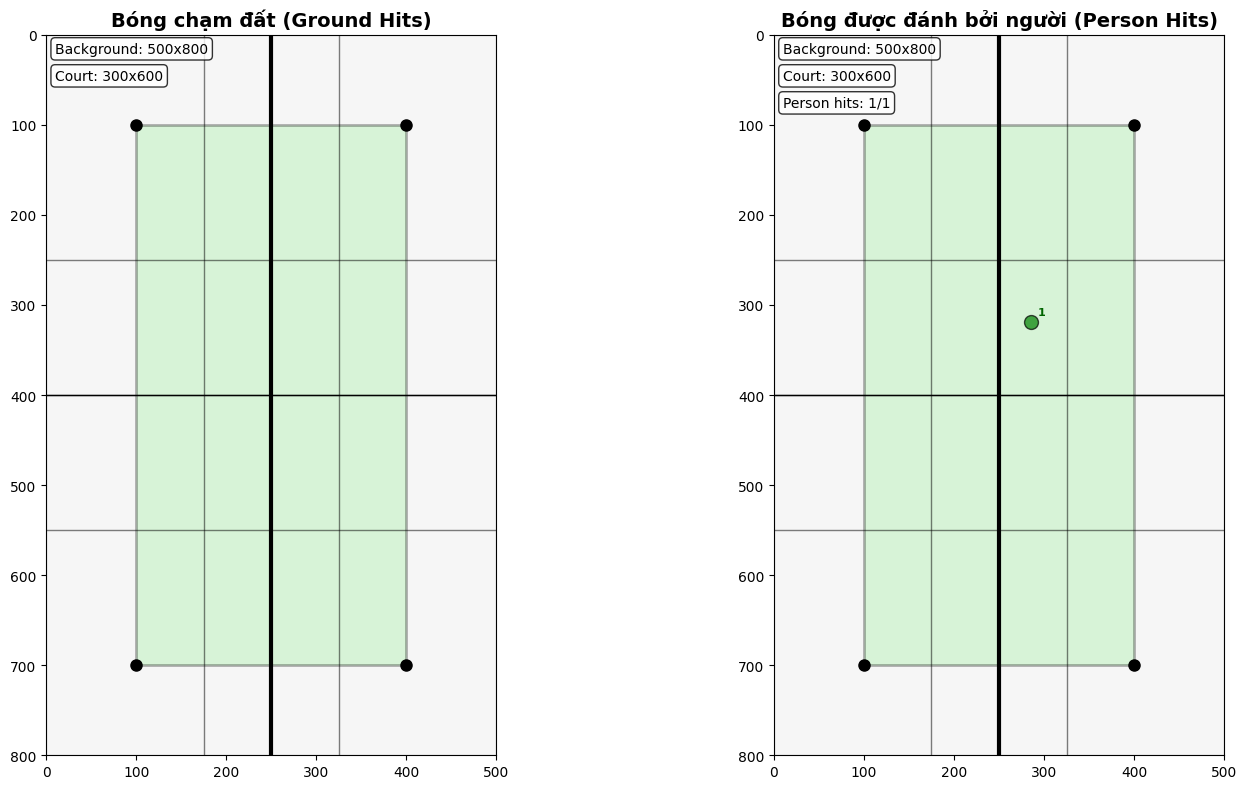

Đã lưu hit map: tennis_hit_map.png
Kích thước background: 500x800
Kích thước sân tennis: 300x600 (ở giữa)

Vị trí bóng chạm đất: 0 điểm
Vị trí bóng được đánh bởi người: 1 điểm


In [48]:
# Tạo hit map vị trí bóng chạm đất trên sân
print("\n=== TẠO HIT MAP ===")

# Tạo hit map với kích thước chính xác: background 500x800, sân 300x600 ở giữa
hit_positions = match_stats.create_hit_map(
    align_matrix=align_matrix,
    background_width=500,
    background_height=800,
    court_width=300,
    court_height=600,
    output_path="tennis_hit_map.png",
    show_heatmap=True
)

print(f"\nVị trí bóng chạm đất: {len(hit_positions['ground_hits'])} điểm")
print(f"Vị trí bóng được đánh bởi người: {len(hit_positions['person_hits'])} điểm")



=== TẠO DASHBOARD THỐNG KÊ ===


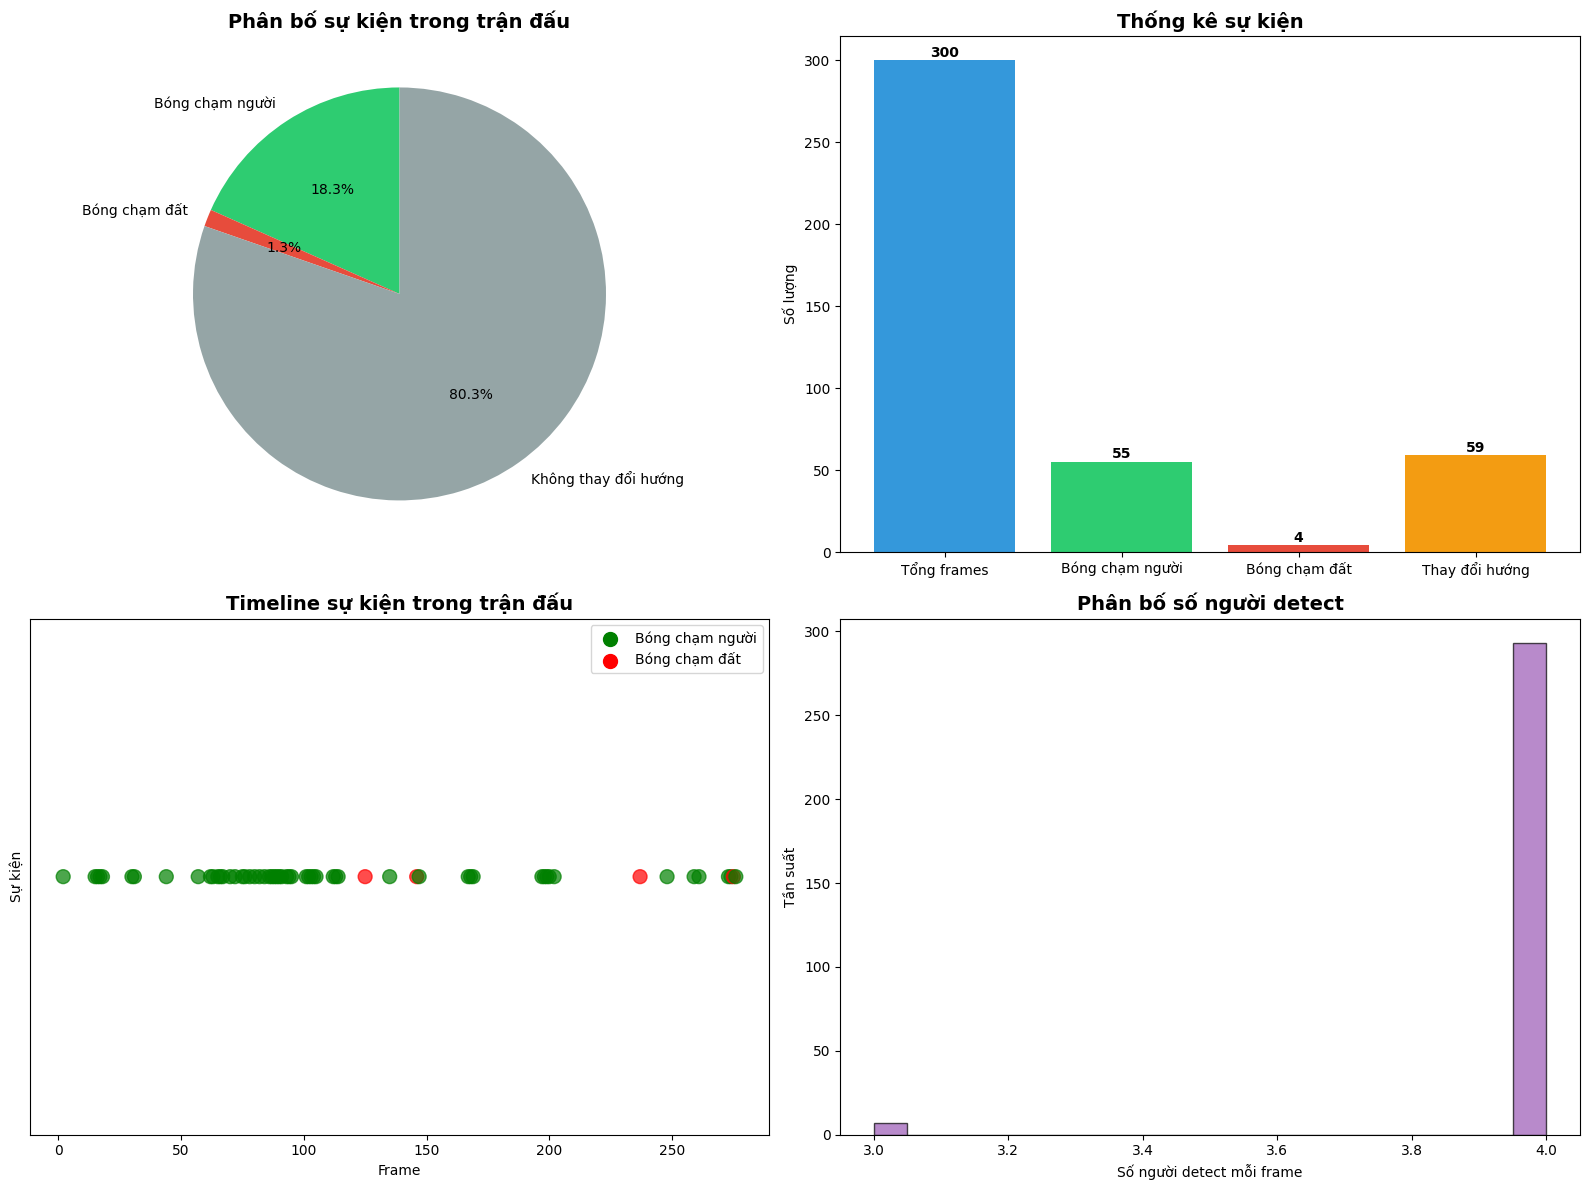

Đã lưu dashboard thống kê: tennis_statistics_dashboard.png

=== XUẤT DỮ LIỆU ===
Đã xuất thống kê ra file CSV: tennis_match_events.csv
Đã xuất 59 sự kiện ra file CSV

5 sự kiện đầu tiên:
   frame  time_seconds  event_type       event_name
0      2      0.066667  person_hit  Bóng chạm người
1     15      0.500000  person_hit  Bóng chạm người
2     16      0.533333  person_hit  Bóng chạm người
3     17      0.566667  person_hit  Bóng chạm người
4     18      0.600000  person_hit  Bóng chạm người


In [26]:
# Tạo dashboard thống kê tổng hợp
print("\n=== TẠO DASHBOARD THỐNG KÊ ===")

# Tạo dashboard với các biểu đồ
match_stats.create_statistics_dashboard(output_path="tennis_statistics_dashboard.png")

# Xuất thống kê ra CSV
print("\n=== XUẤT DỮ LIỆU ===")
events_df = match_stats.export_to_csv("tennis_match_events.csv")
print(f"Đã xuất {len(events_df)} sự kiện ra file CSV")
print("\n5 sự kiện đầu tiên:")
print(events_df.head())


In [27]:
# Hàm tiện ích để phân tích trận đấu hoàn chỉnh
def analyze_tennis_match(video_path, model_path, person_model_path="yolov8m.pt", 
                        ball_conf=0.7, person_conf=0.6, angle_threshold=50, 
                        intersection_threshold=50, output_prefix="tennis_analysis"):
    """
    Hàm tiện ích để phân tích trận đấu tennis hoàn chỉnh với thống kê và hit map.
    """
    print(f"=== PHÂN TÍCH TRẬN ĐẤU TENNIS: {video_path} ===")
    
    # Khởi tạo detector
    detector = BallDetector(model_path, conf=ball_conf, person_model_path=person_model_path)
    
    # Đọc và xử lý video
    print("Đang đọc video...")
    frames = detector.read_video(video_path)
    frames = [distored_image(frame) for frame in frames]
    
    # Detect bóng
    print("Đang detect bóng...")
    positions = detector.detect_positions(frames)
    corrected = detector.correct_positions(positions)
    smoothed = detector.smooth_positions(corrected, threshold_factor=2.5)
    final_positions = detector.interpolate_positions(smoothed, step=5)
    
    # Detect người và phân loại
    print("Đang phân tích tương tác bóng-người...")
    enhanced_flags, person_detections = detector.get_enhanced_direction_change_flags(
        frames=frames,
        positions=final_positions,
        angle_threshold=angle_threshold,
        person_conf=person_conf,
        intersection_threshold=intersection_threshold
    )
    
    # Tạo video kết quả
    print("Đang tạo video kết quả...")
    detector.save_video_with_court_visualization(
        frames=frames,
        positions=final_positions,
        direction_flags=enhanced_flags,
        align_matrix=align_matrix,
        output_path=f"{output_prefix}_with_person_detection.mp4",
        fps=30,
        background_width=500,
        background_height=800,
        person_detections=person_detections
    )
    
    # Tạo thống kê
    print("Đang tạo thống kê...")
    match_stats = MatchStatistics(
        positions=final_positions,
        direction_flags=enhanced_flags,
        person_detections=person_detections,
        fps=30
    )
    
    # In báo cáo
    match_stats.print_detailed_report()
    
    # Tạo hit map
    print("Đang tạo hit map...")
    match_stats.create_hit_map(
        align_matrix=align_matrix,
        background_width=500,
        background_height=800,
        court_width=300,
        court_height=600,
        output_path=f"{output_prefix}_hit_map.png"
    )
    
    # Tạo dashboard
    print("Đang tạo dashboard...")
    match_stats.create_statistics_dashboard(output_path=f"{output_prefix}_dashboard.png")
    
    # Xuất CSV
    print("Đang xuất dữ liệu...")
    events_df = match_stats.export_to_csv(f"{output_prefix}_events.csv")
    
    print(f"\n=== HOÀN THÀNH PHÂN TÍCH ===")
    print(f"Files đã tạo:")
    print(f"- {output_prefix}_with_person_detection.mp4: Video với person detection")
    print(f"- {output_prefix}_hit_map.png: Hit map vị trí bóng")
    print(f"- {output_prefix}_dashboard.png: Dashboard thống kê")
    print(f"- {output_prefix}_events.csv: Dữ liệu sự kiện")
    
    return match_stats, events_df



=== TEST HIT MAP VỚI KÍCH THƯỚC CHÍNH XÁC ===


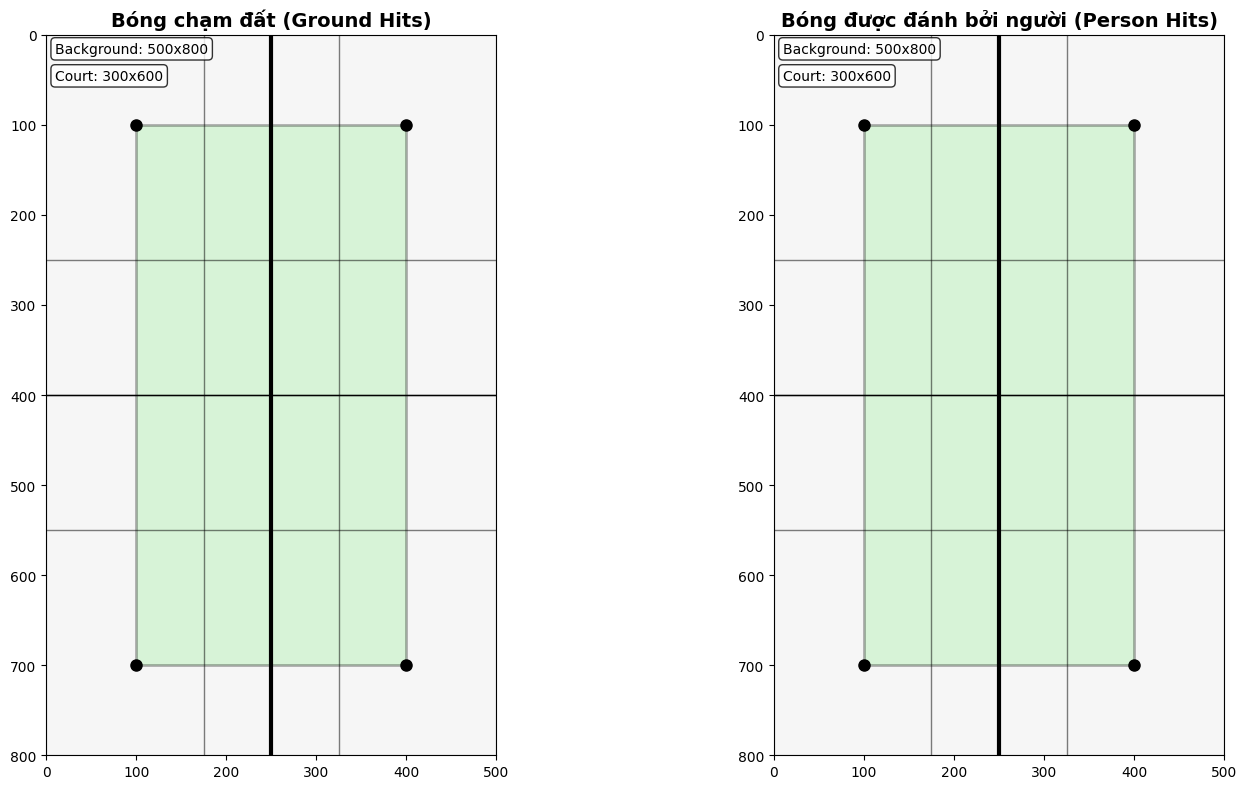

Đã lưu hit map: tennis_hit_map_corrected.png
Kích thước background: 500x800
Kích thước sân tennis: 300x600 (ở giữa)

=== CHI TIẾT VỊ TRÍ BÓNG ===
Tổng số điểm bóng chạm đất: 0
Tổng số điểm bóng được đánh bởi người: 0

Vùng sân tennis:
- X: 100 đến 400
- Y: 100 đến 700

Điểm trong sân:
- Bóng chạm đất: 0/0
- Bóng được đánh bởi người: 0/0


In [28]:
# Test hit map với kích thước chính xác
print("=== TEST HIT MAP VỚI KÍCH THƯỚC CHÍNH XÁC ===")

# Tạo hit map với kích thước chính xác
hit_positions = match_stats.create_hit_map(
    align_matrix=align_matrix,
    background_width=500,
    background_height=800,
    court_width=300,
    court_height=600,
    output_path="tennis_hit_map_corrected.png",
    show_heatmap=True
)

# Hiển thị thông tin chi tiết về vị trí
print(f"\n=== CHI TIẾT VỊ TRÍ BÓNG ===")
print(f"Tổng số điểm bóng chạm đất: {len(hit_positions['ground_hits'])}")
print(f"Tổng số điểm bóng được đánh bởi người: {len(hit_positions['person_hits'])}")

# Kiểm tra vị trí trong sân
court_x_start = (500 - 300) // 2  # 100
court_y_start = (800 - 600) // 2  # 100
court_x_end = court_x_start + 300  # 400
court_y_end = court_y_start + 600  # 700

print(f"\nVùng sân tennis:")
print(f"- X: {court_x_start} đến {court_x_end}")
print(f"- Y: {court_y_start} đến {court_y_end}")

# Đếm điểm trong sân
ground_in_court = sum(1 for x, y, _ in hit_positions['ground_hits'] 
                     if court_x_start <= x <= court_x_end and court_y_start <= y <= court_y_end)
person_in_court = sum(1 for x, y, _ in hit_positions['person_hits'] 
                     if court_x_start <= x <= court_x_end and court_y_start <= y <= court_y_end)

print(f"\nĐiểm trong sân:")
print(f"- Bóng chạm đất: {ground_in_court}/{len(hit_positions['ground_hits'])}")
print(f"- Bóng được đánh bởi người: {person_in_court}/{len(hit_positions['person_hits'])}")

# Hiển thị tọa độ chi tiết
if hit_positions['ground_hits']:
    print(f"\nTọa độ bóng chạm đất:")
    for i, (x, y, frame_idx) in enumerate(hit_positions['ground_hits']):
        in_court = "✓" if (court_x_start <= x <= court_x_end and court_y_start <= y <= court_y_end) else "✗"
        print(f"  {i+1}. Frame {frame_idx}: ({x:.1f}, {y:.1f}) {in_court}")

if hit_positions['person_hits']:
    print(f"\nTọa độ bóng được đánh bởi người:")
    for i, (x, y, frame_idx) in enumerate(hit_positions['person_hits']):
        in_court = "✓" if (court_x_start <= x <= court_x_end and court_y_start <= y <= court_y_end) else "✗"
        print(f"  {i+1}. Frame {frame_idx}: ({x:.1f}, {y:.1f}) {in_court}")


In [29]:
# =============================================================================
# CHỨC NĂNG TRACKING NGƯỜI VÀ POSE ESTIMATION CHO TENNIS ANALYSIS
# =============================================================================

import cv2
import numpy as np
from ultralytics import YOLO
from collections import defaultdict
import math

class PersonTracker:
    """
    Class để tracking người và phân tích pose trong tennis
    """
    
    def __init__(self, pose_model_path="yolov8n-pose.pt", person_model_path="yolov8m.pt"):
        self.pose_model = YOLO(pose_model_path)
        self.person_model = YOLO(person_model_path)
        self.tracked_persons = {}  # {person_id: person_data}
        self.next_person_id = 1
        self.ball_hits_by_person = defaultdict(list)  # {person_id: [hit_data]}
        
    def detect_and_track_persons(self, frames, ball_positions, direction_flags):
        """
        Detect và track người qua các frame
        """
        print("Đang detect và track người...")
        
        person_detections = []
        pose_detections = []
        
        for frame_idx, frame in enumerate(frames):
            # Detect người
            person_results = self.person_model.predict(frame, verbose=False, conf=0.6)
            frame_persons = []
            
            if person_results[0].boxes is not None:
                for box in person_results[0].boxes:
                    if int(box.cls) == 0:  # person class
                        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                        conf = box.conf.cpu().numpy()[0]
                        frame_persons.append({
                            'bbox': (int(x1), int(y1), int(x2), int(y2)),
                            'conf': conf
                        })
            
            # Detect pose
            pose_results = self.pose_model.predict(frame, verbose=False, conf=0.5)
            frame_poses = []
            
            if pose_results[0].keypoints is not None:
                for keypoints in pose_results[0].keypoints:
                    kpts = keypoints.xy[0].cpu().numpy()  # [17, 2] - 17 keypoints
                    conf = keypoints.conf[0].cpu().numpy()  # [17] - confidence for each keypoint
                    frame_poses.append({
                        'keypoints': kpts,
                        'conf': conf
                    })
            
            # Match persons with poses
            matched_data = self._match_persons_with_poses(frame_persons, frame_poses)
            
            # Track persons across frames
            tracked_frame_data = self._track_persons_across_frames(matched_data, frame_idx)
            
            person_detections.append(tracked_frame_data)
            pose_detections.append(frame_poses)
            
            # Check for ball hits by tracked persons
            if frame_idx < len(ball_positions) and ball_positions[frame_idx] != (-1, -1):
                self._check_ball_person_hits(ball_positions[frame_idx], tracked_frame_data, 
                                           direction_flags[frame_idx] if frame_idx < len(direction_flags) else 0, 
                                           frame_idx)
        
        return person_detections, pose_detections
    
    def _match_persons_with_poses(self, persons, poses):
        """
        Match persons với poses dựa trên vị trí bbox
        """
        matched_data = []
        
        for person in persons:
            x1, y1, x2, y2 = person['bbox']
            person_center = ((x1 + x2) / 2, (y1 + y2) / 2)
            
            best_pose = None
            min_distance = float('inf')
            
            for pose in poses:
                # Tính center của pose (trung bình các keypoints)
                valid_keypoints = pose['keypoints'][pose['conf'] > 0.5]
                if len(valid_keypoints) > 0:
                    pose_center = np.mean(valid_keypoints, axis=0)
                    distance = np.linalg.norm(np.array(person_center) - pose_center)
                    
                    if distance < min_distance:
                        min_distance = distance
                        best_pose = pose
            
            matched_data.append({
                'person': person,
                'pose': best_pose,
                'distance': min_distance
            })
        
        return matched_data
    
    def _track_persons_across_frames(self, matched_data, frame_idx):
        """
        Track người qua các frame sử dụng IoU và distance
        """
        tracked_data = []
        
        for data in matched_data:
            person = data['person']
            pose = data['pose']
            
            # Tìm person gần nhất trong frame trước
            best_match_id = None
            best_iou = 0
            
            for person_id, person_data in self.tracked_persons.items():
                if person_data['last_seen'] == frame_idx - 1:  # Chỉ check frame trước
                    iou = self._calculate_iou(person['bbox'], person_data['bbox'])
                    if iou > best_iou and iou > 0.3:  # Threshold IoU
                        best_iou = iou
                        best_match_id = person_id
            
            if best_match_id is not None:
                # Update existing person
                person_id = best_match_id
                self.tracked_persons[person_id].update({
                    'bbox': person['bbox'],
                    'conf': person['conf'],
                    'pose': pose,
                    'last_seen': frame_idx,
                    'frame_count': self.tracked_persons[person_id]['frame_count'] + 1
                })
            else:
                # Create new person
                person_id = self.next_person_id
                self.next_person_id += 1
                self.tracked_persons[person_id] = {
                    'bbox': person['bbox'],
                    'conf': person['conf'],
                    'pose': pose,
                    'first_seen': frame_idx,
                    'last_seen': frame_idx,
                    'frame_count': 1
                }
            
            tracked_data.append({
                'person_id': person_id,
                'person': person,
                'pose': pose
            })
        
        return tracked_data
    
    def _calculate_iou(self, bbox1, bbox2):
        """
        Tính IoU giữa 2 bounding boxes
        """
        x1_1, y1_1, x2_1, y2_1 = bbox1
        x1_2, y1_2, x2_2, y2_2 = bbox2
        
        # Tính intersection
        x1_i = max(x1_1, x1_2)
        y1_i = max(y1_1, y1_2)
        x2_i = min(x2_1, x2_2)
        y2_i = min(y2_1, y2_2)
        
        if x2_i <= x1_i or y2_i <= y1_i:
            return 0.0
        
        intersection = (x2_i - x1_i) * (y2_i - y1_i)
        area1 = (x2_1 - x1_1) * (y2_1 - y1_1)
        area2 = (x2_2 - x1_2) * (y2_2 - y1_2)
        union = area1 + area2 - intersection
        
        return intersection / union if union > 0 else 0.0
    
    def _check_ball_person_hits(self, ball_pos, tracked_persons, direction_flag, frame_idx):
        """
        Kiểm tra bóng có chạm người không và lưu thông tin hit
        """
        if direction_flag == 2:  # Bóng được đánh bởi người
            ball_x, ball_y = ball_pos
            
            for person_data in tracked_persons:
                person_id = person_data['person_id']
                x1, y1, x2, y2 = person_data['person']['bbox']
                
                # Kiểm tra bóng có trong vùng người không
                if x1 <= ball_x <= x2 and y1 <= ball_y <= y2:
                    hit_data = {
                        'frame': frame_idx,
                        'ball_pos': ball_pos,
                        'person_bbox': person_data['person']['bbox'],
                        'pose': person_data['pose'],
                        'person_id': person_id
                    }
                    self.ball_hits_by_person[person_id].append(hit_data)
                    break
    
    def analyze_tennis_technique(self, person_detections, court_bounds):
        """
        Phân tích kỹ thuật tennis dựa trên pose estimation
        """
        print("Đang phân tích kỹ thuật tennis...")
        
        technique_analysis = {
            'person_stats': {},
            'technique_errors': [],
            'pose_analysis': {},
            'court_accuracy': {}
        }
        
        for person_id, person_data in self.tracked_persons.items():
            hits = self.ball_hits_by_person[person_id]
            
            person_stats = {
                'total_hits': len(hits),
                'hits_in_court': 0,
                'hits_out_court': 0,
                'technique_errors': [],
                'hit_details': []  # Chi tiết từng cú đánh
            }
            
            # Phân tích từng cú đánh
            for hit in hits:
                pose = hit['pose']
                ball_pos = hit['ball_pos']
                frame_idx = hit['frame']
                
                # Kiểm tra trong/ngoài sân
                is_in_court = self._is_ball_in_court(ball_pos, court_bounds)
                
                hit_detail = {
                    'frame': frame_idx,
                    'ball_pos': ball_pos,
                    'is_in_court': is_in_court,
                    'pose_analysis': {},
                    'technique_errors': []
                }
                
                if pose is not None:
                    # Phân tích pose
                    pose_analysis = self._analyze_pose(pose, ball_pos, court_bounds)
                    hit_detail['pose_analysis'] = pose_analysis
                    
                    # Kiểm tra lỗi kỹ thuật
                    errors = self._detect_technique_errors(pose, ball_pos, court_bounds)
                    person_stats['technique_errors'].extend(errors)
                    hit_detail['technique_errors'] = errors
                    
                    # Đếm trong/ngoài sân
                    if is_in_court:
                        person_stats['hits_in_court'] += 1
                    else:
                        person_stats['hits_out_court'] += 1
                else:
                    # Nếu không có pose, vẫn đếm trong/ngoài sân
                    if is_in_court:
                        person_stats['hits_in_court'] += 1
                    else:
                        person_stats['hits_out_court'] += 1
                
                person_stats['hit_details'].append(hit_detail)
            
            # Tính tỷ lệ chính xác
            total_hits = person_stats['hits_in_court'] + person_stats['hits_out_court']
            if total_hits > 0:
                person_stats['accuracy_percentage'] = (person_stats['hits_in_court'] / total_hits) * 100
            else:
                person_stats['accuracy_percentage'] = 0
            
            technique_analysis['person_stats'][person_id] = person_stats
        
        # Tính thống kê tổng hợp
        technique_analysis['court_accuracy'] = self._calculate_court_accuracy_summary(technique_analysis['person_stats'])
        
        return technique_analysis
    
    def _calculate_court_accuracy_summary(self, person_stats):
        """
        Tính thống kê tổng hợp về độ chính xác
        """
        # Lọc bỏ những người không có cú đánh nào
        active_persons = {pid: stats for pid, stats in person_stats.items() if stats['total_hits'] > 0}
        
        total_in_court = sum(stats['hits_in_court'] for stats in active_persons.values())
        total_out_court = sum(stats['hits_out_court'] for stats in active_persons.values())
        total_hits = total_in_court + total_out_court
        
        summary = {
            'total_in_court': total_in_court,
            'total_out_court': total_out_court,
            'total_hits': total_hits,
            'overall_accuracy': (total_in_court / total_hits * 100) if total_hits > 0 else 0,
            'by_person': {},
            'active_persons_count': len(active_persons),
            'total_persons_count': len(person_stats)
        }
        
        for person_id, stats in active_persons.items():
            summary['by_person'][person_id] = {
                'hits_in_court': stats['hits_in_court'],
                'hits_out_court': stats['hits_out_court'],
                'total_hits': stats['total_hits'],
                'accuracy_percentage': stats['accuracy_percentage']
            }
        
        return summary
    
    def _analyze_pose(self, pose, ball_pos, court_bounds):
        """
        Phân tích pose để xác định tư thế đánh bóng
        """
        if pose is None:
            return {}
        
        keypoints = pose['keypoints']
        conf = pose['conf']
        
        # COCO keypoints: 0=nose, 1=left_eye, 2=right_eye, 3=left_ear, 4=right_ear,
        # 5=left_shoulder, 6=right_shoulder, 7=left_elbow, 8=right_elbow,
        # 9=left_wrist, 10=right_wrist, 11=left_hip, 12=right_hip,
        # 13=left_knee, 14=right_knee, 15=left_ankle, 16=right_ankle
        
        analysis = {}
        
        # Kiểm tra keypoints có confidence cao
        valid_keypoints = conf > 0.5
        
        if valid_keypoints[5] and valid_keypoints[6]:  # Shoulders
            left_shoulder = keypoints[5]
            right_shoulder = keypoints[6]
            shoulder_angle = self._calculate_angle(left_shoulder, right_shoulder, ball_pos)
            analysis['shoulder_angle'] = shoulder_angle
        
        if valid_keypoints[13] and valid_keypoints[14]:  # Knees
            left_knee = keypoints[13]
            right_knee = keypoints[14]
            knee_bend = self._calculate_knee_bend(left_knee, right_knee)
            analysis['knee_bend'] = knee_bend
        
        if valid_keypoints[9] and valid_keypoints[10]:  # Wrists
            left_wrist = keypoints[9]
            right_wrist = keypoints[10]
            racket_position = self._estimate_racket_position(left_wrist, right_wrist, ball_pos)
            analysis['racket_position'] = racket_position
        
        return analysis
    
    def _detect_technique_errors(self, pose, ball_pos, court_bounds):
        """
        Phát hiện lỗi kỹ thuật tennis
        """
        errors = []
        
        if pose is None:
            return errors
        
        keypoints = pose['keypoints']
        conf = pose['conf']
        
        # 1. Kiểm tra khụy gối (knee bend)
        if conf[13] > 0.5 and conf[14] > 0.5:  # Knees
            left_knee = keypoints[13]
            right_knee = keypoints[14]
            knee_bend = self._calculate_knee_bend(left_knee, right_knee)
            
            if knee_bend < 120:  # Góc khụy gối quá nhỏ
                errors.append({
                    'type': 'insufficient_knee_bend',
                    'description': 'Khụy gối không đủ sâu',
                    'severity': 'medium'
                })
        
        # 2. Kiểm tra vị trí chân (foot position)
        if conf[15] > 0.5 and conf[16] > 0.5:  # Ankles
            left_ankle = keypoints[15]
            right_ankle = keypoints[16]
            
            # Kiểm tra dẫm vạch
            if self._is_stepping_on_line(left_ankle, right_ankle, court_bounds):
                errors.append({
                    'type': 'stepping_on_line',
                    'description': 'Dẫm vạch khi đánh bóng',
                    'severity': 'high'
                })
        
        # 3. Kiểm tra tư thế sau khi đánh bóng
        if conf[5] > 0.5 and conf[6] > 0.5:  # Shoulders
            left_shoulder = keypoints[5]
            right_shoulder = keypoints[6]
            
            # Kiểm tra follow-through
            follow_through = self._check_follow_through(left_shoulder, right_shoulder, ball_pos)
            if not follow_through:
                errors.append({
                    'type': 'poor_follow_through',
                    'description': 'Tư thế sau khi đánh bóng không tốt',
                    'severity': 'low'
                })
        
        return errors
    
    def _calculate_angle(self, p1, p2, p3):
        """
        Tính góc giữa 3 điểm
        """
        v1 = p1 - p3
        v2 = p2 - p3
        
        cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        cos_angle = np.clip(cos_angle, -1.0, 1.0)
        
        return np.arccos(cos_angle) * 180 / np.pi
    
    def _calculate_knee_bend(self, left_knee, right_knee):
        """
        Tính góc khụy gối
        """
        # Simplified: tính góc giữa 2 đầu gối
        return self._calculate_angle(left_knee, right_knee, (left_knee + right_knee) / 2)
    
    def _estimate_racket_position(self, left_wrist, right_wrist, ball_pos):
        """
        Ước tính vị trí vợt dựa trên vị trí cổ tay
        """
        wrist_center = (left_wrist + right_wrist) / 2
        distance_to_ball = np.linalg.norm(wrist_center - ball_pos)
        return distance_to_ball
    
    def _is_ball_in_court(self, ball_pos, court_bounds):
        """
        Kiểm tra bóng có trong sân không
        """
        x, y = ball_pos
        x1, y1, x2, y2 = court_bounds
        return x1 <= x <= x2 and y1 <= y <= y2
    
    def _is_stepping_on_line(self, left_ankle, right_ankle, court_bounds):
        """
        Kiểm tra có dẫm vạch không
        """
        # Simplified: kiểm tra chân có gần vạch không
        x1, y1, x2, y2 = court_bounds
        
        # Kiểm tra vạch ngang (net)
        net_y = (y1 + y2) / 2
        if abs(left_ankle[1] - net_y) < 20 or abs(right_ankle[1] - net_y) < 20:
            return True
        
        # Kiểm tra vạch dọc
        if abs(left_ankle[0] - x1) < 20 or abs(left_ankle[0] - x2) < 20:
            return True
        if abs(right_ankle[0] - x1) < 20 or abs(right_ankle[0] - x2) < 20:
            return True
        
        return False
    
    def _check_follow_through(self, left_shoulder, right_shoulder, ball_pos):
        """
        Kiểm tra follow-through sau khi đánh bóng
        """
        # Simplified: kiểm tra vai có di chuyển theo hướng đánh bóng không
        shoulder_center = (left_shoulder + right_shoulder) / 2
        distance = np.linalg.norm(shoulder_center - ball_pos)
        return distance < 100  # Threshold
    
    def get_person_statistics(self):
        """
        Lấy thống kê tổng hợp về người chơi
        """
        stats = {}
        
        for person_id, person_data in self.tracked_persons.items():
            hits = self.ball_hits_by_person[person_id]
            
            stats[person_id] = {
                'total_frames': person_data['frame_count'],
                'total_hits': len(hits),
                'hit_rate': len(hits) / person_data['frame_count'] if person_data['frame_count'] > 0 else 0,
                'first_seen': person_data['first_seen'],
                'last_seen': person_data['last_seen']
            }
        
        return stats


In [30]:
# =============================================================================
# TÍCH HỢP PERSON TRACKING VÀO PHÂN TÍCH CHÍNH
# =============================================================================

def analyze_tennis_with_person_tracking(video_path, ball_model_path="ball_best.pt", 
                                       person_model_path="yolov8m.pt", 
                                       pose_model_path="yolov8m-pose.pt"):
    """
    Phân tích tennis với tracking người và pose estimation
    """
    print("=" * 80)
    print("           TENNIS ANALYSIS WITH PERSON TRACKING & POSE ESTIMATION")
    print("=" * 80)
    
    # 1. Load video
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"📹 Video: {video_path}")
    print(f"🎬 FPS: {fps}, Total frames: {total_frames}")
    
    # 2. Initialize models
    ball_detector = BallDetector(ball_model_path, person_model_path)
    person_tracker = PersonTracker(pose_model_path, person_model_path)
    
    # 3. Process video
    frames = []
    ball_positions = []
    
    print("Đang đọc video...")
    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frames.append(frame)
        frame_count += 1
        
        if frame_count % 100 == 0:
            print(f"Đã đọc {frame_count}/{total_frames} frames...")
    
    cap.release()
    print(f"✅ Đã đọc xong {len(frames)} frames")
    
    # 4. Detect ball
    print("Đang detect bóng...")
    ball_positions = ball_detector.detect_positions(frames)
    
    # 5. Detect direction changes
    print("Đang phân tích thay đổi hướng...")
    direction_flags, person_detections_old = ball_detector.get_enhanced_direction_change_flags(
        frames, ball_positions, angle_threshold=50, person_conf=0.6, intersection_threshold=100
    )
    
    # 6. Person tracking và pose estimation
    print("Đang tracking người và phân tích pose...")
    person_detections, pose_detections = person_tracker.detect_and_track_persons(
        frames, ball_positions, direction_flags
    )
    
    # 7. Phân tích kỹ thuật tennis
    court_bounds = (100, 100, 400, 500)  # x1, y1, x2, y2
    technique_analysis = person_tracker.analyze_tennis_technique(person_detections, court_bounds)
    
    # 8. Tính toán thống kê
    person_stats = person_tracker.get_person_statistics()
    
    # 9. Tạo báo cáo
    print("\n" + "="*80)
    print("=== BÁO CÁO PHÂN TÍCH TENNIS VỚI PERSON TRACKING ===")
    print("="*80)
    
    print(f"\n📊 THỐNG KÊ TỔNG QUAN:")
    print(f"- Tổng số frames: {len(frames)}")
    print(f"- Tổng thời gian: {len(frames)/fps:.2f} giây")
    print(f"- Số người được track: {len(person_tracker.tracked_persons)}")
    
    print(f"\n🎾 THỐNG KÊ BÓNG:")
    ball_hits = sum(1 for flag in direction_flags if flag > 0)
    person_hits = sum(1 for flag in direction_flags if flag == 2)
    ground_hits = sum(1 for flag in direction_flags if flag == 1)
    
    print(f"- Tổng cú đánh: {ball_hits}")
    print(f"- Cú đánh bởi người: {person_hits}")
    print(f"- Cú đánh chạm đất: {ground_hits}")
    
    print(f"\n👥 THỐNG KÊ NGƯỜI CHƠI:")
    for person_id, stats in person_stats.items():
        print(f"\nNgười chơi {person_id}:")
        print(f"  - Tổng frames xuất hiện: {stats['total_frames']}")
        print(f"  - Tổng cú đánh: {stats['total_hits']}")
        print(f"  - Tỷ lệ đánh bóng: {stats['hit_rate']:.2%}")
        print(f"  - Xuất hiện từ frame: {stats['first_seen']}")
        print(f"  - Xuất hiện đến frame: {stats['last_seen']}")
    
    print(f"\n🏆 PHÂN TÍCH KỸ THUẬT VÀ ĐỘ CHÍNH XÁC:")
    
    # Thống kê tổng hợp
    court_accuracy = technique_analysis['court_accuracy']
    print(f"\n📊 THỐNG KÊ TỔNG HỢP:")
    print(f"  - Tổng cú đánh: {court_accuracy['total_hits']}")
    print(f"  - Cú đánh trong sân: {court_accuracy['total_in_court']}")
    print(f"  - Cú đánh ngoài sân: {court_accuracy['total_out_court']}")
    print(f"  - Tỷ lệ chính xác tổng: {court_accuracy['overall_accuracy']:.1f}%")
    
    # Thống kê từng người chơi (chỉ hiển thị những người có cú đánh)
    print(f"\n👥 THỐNG KÊ TỪNG NGƯỜI CHƠI:")
    print(f"📊 Tổng số người được track: {court_accuracy['total_persons_count']}")
    print(f"🎾 Số người có cú đánh: {court_accuracy['active_persons_count']}")
    
    # Lọc chỉ hiển thị những người có cú đánh
    active_persons = {pid: stats for pid, stats in technique_analysis['person_stats'].items() if stats['total_hits'] > 0}
    
    if not active_persons:
        print("❌ Không có người chơi nào có cú đánh!")
    else:
        for person_id, person_data in active_persons.items():
            print(f"\n🎾 NGƯỜI CHƠI {person_id}:")
            print(f"  📈 Tổng cú đánh: {person_data['total_hits']}")
            print(f"  ✅ Cú đánh trong sân: {person_data['hits_in_court']}")
            print(f"  ❌ Cú đánh ngoài sân: {person_data['hits_out_court']}")
            print(f"  🎯 Tỷ lệ chính xác: {person_data['accuracy_percentage']:.1f}%")
            
            # Chi tiết từng cú đánh
            if person_data['hit_details']:
                print(f"  📝 CHI TIẾT CÁC CÚ ĐÁNH:")
                for i, hit_detail in enumerate(person_data['hit_details'], 1):
                    status = "✅ TRONG SÂN" if hit_detail['is_in_court'] else "❌ NGOÀI SÂN"
                    print(f"    Cú {i}: Frame {hit_detail['frame']} - {status} - Vị trí: {hit_detail['ball_pos']}")
            
            # Lỗi kỹ thuật
            if person_data['technique_errors']:
                print(f"  ⚠️  Lỗi kỹ thuật phát hiện: {len(person_data['technique_errors'])}")
                error_types = {}
                for error in person_data['technique_errors']:
                    error_type = error['type']
                    error_types[error_type] = error_types.get(error_type, 0) + 1
                
                for error_type, count in error_types.items():
                    print(f"    + {error_type}: {count} lần")
            else:
                print(f"  ✅ Không có lỗi kỹ thuật phát hiện")
    
    # 10. Tính vận tốc bóng tại các vị trí đánh
    print(f"\n⚡ PHÂN TÍCH VẬN TỐC BÓNG:")
    velocities = []
    for person_id, hits in person_tracker.ball_hits_by_person.items():
        for hit in hits:
            frame_idx = hit['frame']
            if frame_idx > 0 and frame_idx < len(ball_positions) - 1:
                # Tính vận tốc dựa trên vị trí trước và sau
                prev_pos = ball_positions[frame_idx - 1] if ball_positions[frame_idx - 1] != (-1, -1) else None
                next_pos = ball_positions[frame_idx + 1] if ball_positions[frame_idx + 1] != (-1, -1) else None
                
                if prev_pos and next_pos:
                    # Tính khoảng cách di chuyển
                    distance = np.sqrt((next_pos[0] - prev_pos[0])**2 + (next_pos[1] - prev_pos[1])**2)
                    # Vận tốc (pixels per frame)
                    velocity = distance / 2  # 2 frames
                    velocities.append(velocity)
                    
                    print(f"  - Người {person_id}, Frame {frame_idx}: Vận tốc = {velocity:.2f} pixels/frame")
    
    if velocities:
        print(f"\n📈 THỐNG KÊ VẬN TỐC:")
        print(f"  - Vận tốc trung bình: {np.mean(velocities):.2f} pixels/frame")
        print(f"  - Vận tốc tối đa: {np.max(velocities):.2f} pixels/frame")
        print(f"  - Vận tốc tối thiểu: {np.min(velocities):.2f} pixels/frame")
    
    return {
        'person_tracker': person_tracker,
        'technique_analysis': technique_analysis,
        'person_stats': person_stats,
        'ball_positions': ball_positions,
        'direction_flags': direction_flags,
        'velocities': velocities,
        'frames': frames  # Thêm frames vào kết quả
    }


In [31]:
# =============================================================================
# VISUALIZATION CHO PERSON TRACKING VÀ POSE ESTIMATION
# =============================================================================

def create_pose_visualization(frames, person_detections, pose_detections, output_path="tennis_pose_analysis.mp4"):
    """
    Tạo video visualization cho pose estimation và person tracking
    """
    print("Đang tạo video visualization...")
    
    if not frames:
        print("Không có frames để xử lý!")
        return
    
    # Tạo video writer
    height, width = frames[0].shape[:2]
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, 30.0, (width, height))
    
    # COCO keypoint connections
    skeleton = [
        [0, 1], [0, 2], [1, 3], [2, 4],  # Head
        [5, 6], [5, 7], [7, 9], [6, 8], [8, 10],  # Arms
        [5, 11], [6, 12], [11, 12],  # Torso
        [11, 13], [12, 14], [13, 15], [14, 16]  # Legs
    ]
    
    # Colors for different persons
    person_colors = [
        (255, 0, 0),    # Red
        (0, 255, 0),    # Green
        (0, 0, 255),    # Blue
        (255, 255, 0),  # Cyan
        (255, 0, 255),  # Magenta
        (0, 255, 255),  # Yellow
    ]
    
    for frame_idx, frame in enumerate(frames):
        vis_frame = frame.copy()
        
        # Draw person detections
        if frame_idx < len(person_detections):
            for person_data in person_detections[frame_idx]:
                person_id = person_data['person_id']
                bbox = person_data['person']['bbox']
                pose = person_data['pose']
                
                # Color for this person
                color = person_colors[person_id % len(person_colors)]
                
                # Draw bounding box
                x1, y1, x2, y2 = bbox
                cv2.rectangle(vis_frame, (x1, y1), (x2, y2), color, 2)
                cv2.putText(vis_frame, f"Person {person_id}", (x1, y1-10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
                
                # Draw pose keypoints
                if pose is not None:
                    keypoints = pose['keypoints']
                    conf = pose['conf']
                    
                    # Draw keypoints
                    for i, (x, y) in enumerate(keypoints):
                        if conf[i] > 0.5:  # Only draw confident keypoints
                            cv2.circle(vis_frame, (int(x), int(y)), 3, color, -1)
                    
                    # Draw skeleton
                    for connection in skeleton:
                        pt1_idx, pt2_idx = connection
                        if (pt1_idx < len(keypoints) and pt2_idx < len(keypoints) and 
                            conf[pt1_idx] > 0.5 and conf[pt2_idx] > 0.5):
                            
                            pt1 = (int(keypoints[pt1_idx][0]), int(keypoints[pt1_idx][1]))
                            pt2 = (int(keypoints[pt2_idx][0]), int(keypoints[pt2_idx][1]))
                            cv2.line(vis_frame, pt1, pt2, color, 2)
        
        # Add frame info
        cv2.putText(vis_frame, f"Frame: {frame_idx}", (10, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        
        out.write(vis_frame)
        
        if frame_idx % 100 == 0:
            print(f"Đã xử lý {frame_idx}/{len(frames)} frames...")
    
    out.release()
    print(f"✅ Đã tạo video: {output_path}")

def create_technique_analysis_plot(technique_analysis, output_path="tennis_technique_analysis.png"):
    """
    Tạo biểu đồ phân tích kỹ thuật tennis
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    person_stats = technique_analysis['person_stats']
    
    if not person_stats:
        print("Không có dữ liệu người chơi để phân tích!")
        return
    
    # Tạo subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('TENNIS TECHNIQUE ANALYSIS', fontsize=16, fontweight='bold')
    
    # 1. Hit accuracy by person
    ax1 = axes[0, 0]
    person_ids = list(person_stats.keys())
    hits_in_court = [person_stats[pid]['hits_in_court'] for pid in person_ids]
    hits_out_court = [person_stats[pid]['hits_out_court'] for pid in person_ids]
    
    x = np.arange(len(person_ids))
    width = 0.35
    
    ax1.bar(x - width/2, hits_in_court, width, label='In Court', color='green', alpha=0.7)
    ax1.bar(x + width/2, hits_out_court, width, label='Out Court', color='red', alpha=0.7)
    
    ax1.set_xlabel('Person ID')
    ax1.set_ylabel('Number of Hits')
    ax1.set_title('Hit Accuracy by Person')
    ax1.set_xticks(x)
    ax1.set_xticklabels([f'Person {pid}' for pid in person_ids])
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Accuracy percentage
    ax2 = axes[0, 1]
    accuracy_percentages = []
    for pid in person_ids:
        total_hits = person_stats[pid]['hits_in_court'] + person_stats[pid]['hits_out_court']
        if total_hits > 0:
            accuracy = person_stats[pid]['hits_in_court'] / total_hits * 100
        else:
            accuracy = 0
        accuracy_percentages.append(accuracy)
    
    bars = ax2.bar([f'Person {pid}' for pid in person_ids], accuracy_percentages, 
                   color=['green' if acc > 70 else 'orange' if acc > 50 else 'red' for acc in accuracy_percentages])
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Hit Accuracy Percentage')
    ax2.set_ylim(0, 100)
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, acc in zip(bars, accuracy_percentages):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{acc:.1f}%', ha='center', va='bottom')
    
    # 3. Technique errors
    ax3 = axes[1, 0]
    error_counts = {}
    for pid, stats in person_stats.items():
        for error in stats['technique_errors']:
            error_type = error['type']
            error_counts[error_type] = error_counts.get(error_type, 0) + 1
    
    if error_counts:
        error_types = list(error_counts.keys())
        error_values = list(error_counts.values())
        
        bars = ax3.bar(error_types, error_values, color='red', alpha=0.7)
        ax3.set_ylabel('Number of Errors')
        ax3.set_title('Technique Errors by Type')
        ax3.tick_params(axis='x', rotation=45)
        ax3.grid(True, alpha=0.3)
        
        # Add value labels
        for bar, value in zip(bars, error_values):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    str(value), ha='center', va='bottom')
    else:
        ax3.text(0.5, 0.5, 'No technique errors detected', 
                ha='center', va='center', transform=ax3.transAxes, fontsize=12)
        ax3.set_title('Technique Errors by Type')
    
    # 4. Total hits by person
    ax4 = axes[1, 1]
    total_hits = [person_stats[pid]['hits_in_court'] + person_stats[pid]['hits_out_court'] 
                  for pid in person_ids]
    
    bars = ax4.bar([f'Person {pid}' for pid in person_ids], total_hits, 
                   color='blue', alpha=0.7)
    ax4.set_ylabel('Total Hits')
    ax4.set_title('Total Hits by Person')
    ax4.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, value in zip(bars, total_hits):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                str(value), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Đã tạo biểu đồ: {output_path}")

def create_detailed_technique_report(person_tracker, technique_analysis, output_path="tennis_detailed_report.txt"):
    """
    Tạo báo cáo chi tiết về kỹ thuật tennis
    """
    with open(output_path, 'w', encoding='utf-8') as f:
        f.write("=" * 80 + "\n")
        f.write("           BÁO CÁO CHI TIẾT KỸ THUẬT TENNIS\n")
        f.write("=" * 80 + "\n\n")
        
        person_stats = technique_analysis['person_stats']
        court_accuracy = technique_analysis['court_accuracy']
        
        # Thống kê tổng hợp
        f.write("THỐNG KÊ TỔNG HỢP:\n")
        f.write("-" * 40 + "\n")
        f.write(f"Tổng cú đánh: {court_accuracy['total_hits']}\n")
        f.write(f"Cú đánh trong sân: {court_accuracy['total_in_court']}\n")
        f.write(f"Cú đánh ngoài sân: {court_accuracy['total_out_court']}\n")
        f.write(f"Tỷ lệ chính xác tổng: {court_accuracy['overall_accuracy']:.1f}%\n\n")
        
        # Lọc chỉ những người có cú đánh
        active_persons = {pid: stats for pid, stats in person_stats.items() if stats['total_hits'] > 0}
        
        f.write(f"Tổng số người được track: {court_accuracy['total_persons_count']}\n")
        f.write(f"Số người có cú đánh: {court_accuracy['active_persons_count']}\n\n")
        
        if not active_persons:
            f.write("❌ Không có người chơi nào có cú đánh!\n\n")
        else:
            for person_id, stats in active_persons.items():
                f.write(f"NGƯỜI CHƠI {person_id}:\n")
                f.write("-" * 40 + "\n")
                
                # Thống kê cơ bản
                f.write(f"Tổng cú đánh: {stats['total_hits']}\n")
                f.write(f"Cú đánh trong sân: {stats['hits_in_court']}\n")
                f.write(f"Cú đánh ngoài sân: {stats['hits_out_court']}\n")
                f.write(f"Tỷ lệ chính xác: {stats['accuracy_percentage']:.1f}%\n")
            
                # Phân tích lỗi kỹ thuật
                f.write(f"\nLỗi kỹ thuật phát hiện: {len(stats['technique_errors'])}\n")
                
                if stats['technique_errors']:
                    error_types = {}
                    for error in stats['technique_errors']:
                        error_type = error['type']
                        error_types[error_type] = error_types.get(error_type, 0) + 1
                    
                    for error_type, count in error_types.items():
                        f.write(f"  - {error_type}: {count} lần\n")
                        
                        # Mô tả lỗi
                        if error_type == 'insufficient_knee_bend':
                            f.write("    → Khụy gối không đủ sâu, ảnh hưởng đến lực đánh bóng\n")
                        elif error_type == 'stepping_on_line':
                            f.write("    → Dẫm vạch khi đánh bóng, vi phạm luật chơi\n")
                        elif error_type == 'poor_follow_through':
                            f.write("    → Tư thế sau khi đánh bóng không tốt\n")
                else:
                    f.write("  - Không có lỗi kỹ thuật phát hiện\n")
                
                # Chi tiết từng cú đánh
                if stats['hit_details']:
                    f.write(f"\nChi tiết {len(stats['hit_details'])} cú đánh:\n")
                    for i, hit_detail in enumerate(stats['hit_details'], 1):
                        status = "TRONG SÂN" if hit_detail['is_in_court'] else "NGOÀI SÂN"
                        f.write(f"  Cú đánh {i}:\n")
                        f.write(f"    - Frame: {hit_detail['frame']}\n")
                        f.write(f"    - Vị trí bóng: {hit_detail['ball_pos']}\n")
                        f.write(f"    - Trạng thái: {status}\n")
                        
                        if hit_detail['pose_analysis']:
                            pose_analysis = hit_detail['pose_analysis']
                            if 'shoulder_angle' in pose_analysis:
                                f.write(f"    - Góc vai: {pose_analysis['shoulder_angle']:.1f}°\n")
                            if 'knee_bend' in pose_analysis:
                                f.write(f"    - Góc khụy gối: {pose_analysis['knee_bend']:.1f}°\n")
                            if 'racket_position' in pose_analysis:
                                f.write(f"    - Khoảng cách vợt-bóng: {pose_analysis['racket_position']:.1f} pixels\n")
                        
                        if hit_detail['technique_errors']:
                            f.write(f"    - Lỗi kỹ thuật: {len(hit_detail['technique_errors'])} lỗi\n")
                            for error in hit_detail['technique_errors']:
                                f.write(f"      + {error['type']}: {error['description']}\n")
                
                f.write("\n" + "=" * 80 + "\n\n")
    
    print(f"✅ Đã tạo báo cáo chi tiết: {output_path}")

def create_court_accuracy_visualization(technique_analysis, output_path="tennis_court_accuracy.png"):
    """
    Tạo biểu đồ visualization cho độ chính xác cú đánh
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    person_stats = technique_analysis['person_stats']
    court_accuracy = technique_analysis['court_accuracy']
    
    # Lọc chỉ những người có cú đánh
    active_persons = {pid: stats for pid, stats in person_stats.items() if stats['total_hits'] > 0}
    
    if not active_persons:
        print("Không có người chơi nào có cú đánh để tạo biểu đồ!")
        return
    
    # Tạo subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('TENNIS COURT ACCURACY ANALYSIS', fontsize=16, fontweight='bold')
    
    # 1. Biểu đồ cột so sánh trong/ngoài sân
    ax1 = axes[0, 0]
    person_ids = list(active_persons.keys())
    hits_in_court = [active_persons[pid]['hits_in_court'] for pid in person_ids]
    hits_out_court = [active_persons[pid]['hits_out_court'] for pid in person_ids]
    
    x = np.arange(len(person_ids))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, hits_in_court, width, label='Trong sân', color='green', alpha=0.7)
    bars2 = ax1.bar(x + width/2, hits_out_court, width, label='Ngoài sân', color='red', alpha=0.7)
    
    ax1.set_xlabel('Người chơi')
    ax1.set_ylabel('Số cú đánh')
    ax1.set_title('So sánh cú đánh trong/ngoài sân')
    ax1.set_xticks(x)
    ax1.set_xticklabels([f'Người {pid}' for pid in person_ids])
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Thêm giá trị trên cột
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)}', ha='center', va='bottom')
    for bar in bars2:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)}', ha='center', va='bottom')
    
    # 2. Biểu đồ tỷ lệ chính xác
    ax2 = axes[0, 1]
    accuracy_percentages = [active_persons[pid]['accuracy_percentage'] for pid in person_ids]
    
    bars = ax2.bar([f'Người {pid}' for pid in person_ids], accuracy_percentages, 
                   color=['green' if acc > 70 else 'orange' if acc > 50 else 'red' for acc in accuracy_percentages])
    ax2.set_ylabel('Tỷ lệ chính xác (%)')
    ax2.set_title('Tỷ lệ chính xác từng người chơi')
    ax2.set_ylim(0, 100)
    ax2.grid(True, alpha=0.3)
    
    # Thêm giá trị trên cột
    for bar, acc in zip(bars, accuracy_percentages):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{acc:.1f}%', ha='center', va='bottom')
    
    # 3. Biểu đồ tròn tổng hợp
    ax3 = axes[1, 0]
    labels = ['Trong sân', 'Ngoài sân']
    sizes = [court_accuracy['total_in_court'], court_accuracy['total_out_court']]
    colors = ['green', 'red']
    
    wedges, texts, autotexts = ax3.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax3.set_title('Phân bố tổng cú đánh')
    
    # 4. Biểu đồ so sánh tổng cú đánh
    ax4 = axes[1, 1]
    total_hits = [active_persons[pid]['total_hits'] for pid in person_ids]
    
    bars = ax4.bar([f'Người {pid}' for pid in person_ids], total_hits, 
                   color='blue', alpha=0.7)
    ax4.set_ylabel('Tổng cú đánh')
    ax4.set_title('Tổng cú đánh từng người chơi')
    ax4.grid(True, alpha=0.3)
    
    # Thêm giá trị trên cột
    for bar, value in zip(bars, total_hits):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(value)}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Đã tạo biểu đồ độ chính xác: {output_path}")


🚀 BẮT ĐẦU PHÂN TÍCH TENNIS VỚI PERSON TRACKING & POSE ESTIMATION
           TENNIS ANALYSIS WITH PERSON TRACKING & POSE ESTIMATION
📹 Video: crop_video/part_008.mp4
🎬 FPS: 30.0, Total frames: 300
Đang đọc video...
Đã đọc 100/300 frames...
Đã đọc 200/300 frames...
Đã đọc 300/300 frames...
✅ Đã đọc xong 300 frames
Đang detect bóng...
Đang phân tích thay đổi hướng...
Đang detect người trong video...
Đang phân tích thay đổi hướng...
Phân loại hoàn tất:
- Bóng chạm người: 54 lần
- Bóng chạm đất: 4 lần
- Tổng thay đổi hướng: 58 lần
Đang tracking người và phân tích pose...
Đang detect và track người...
Đang phân tích kỹ thuật tennis...

=== BÁO CÁO PHÂN TÍCH TENNIS VỚI PERSON TRACKING ===

📊 THỐNG KÊ TỔNG QUAN:
- Tổng số frames: 300
- Tổng thời gian: 10.00 giây
- Số người được track: 9

🎾 THỐNG KÊ BÓNG:
- Tổng cú đánh: 58
- Cú đánh bởi người: 54
- Cú đánh chạm đất: 4

👥 THỐNG KÊ NGƯỜI CHƠI:

Người chơi 1:
  - Tổng frames xuất hiện: 300
  - Tổng cú đánh: 0
  - Tỷ lệ đánh bóng: 0.00%
  - Xuất hi

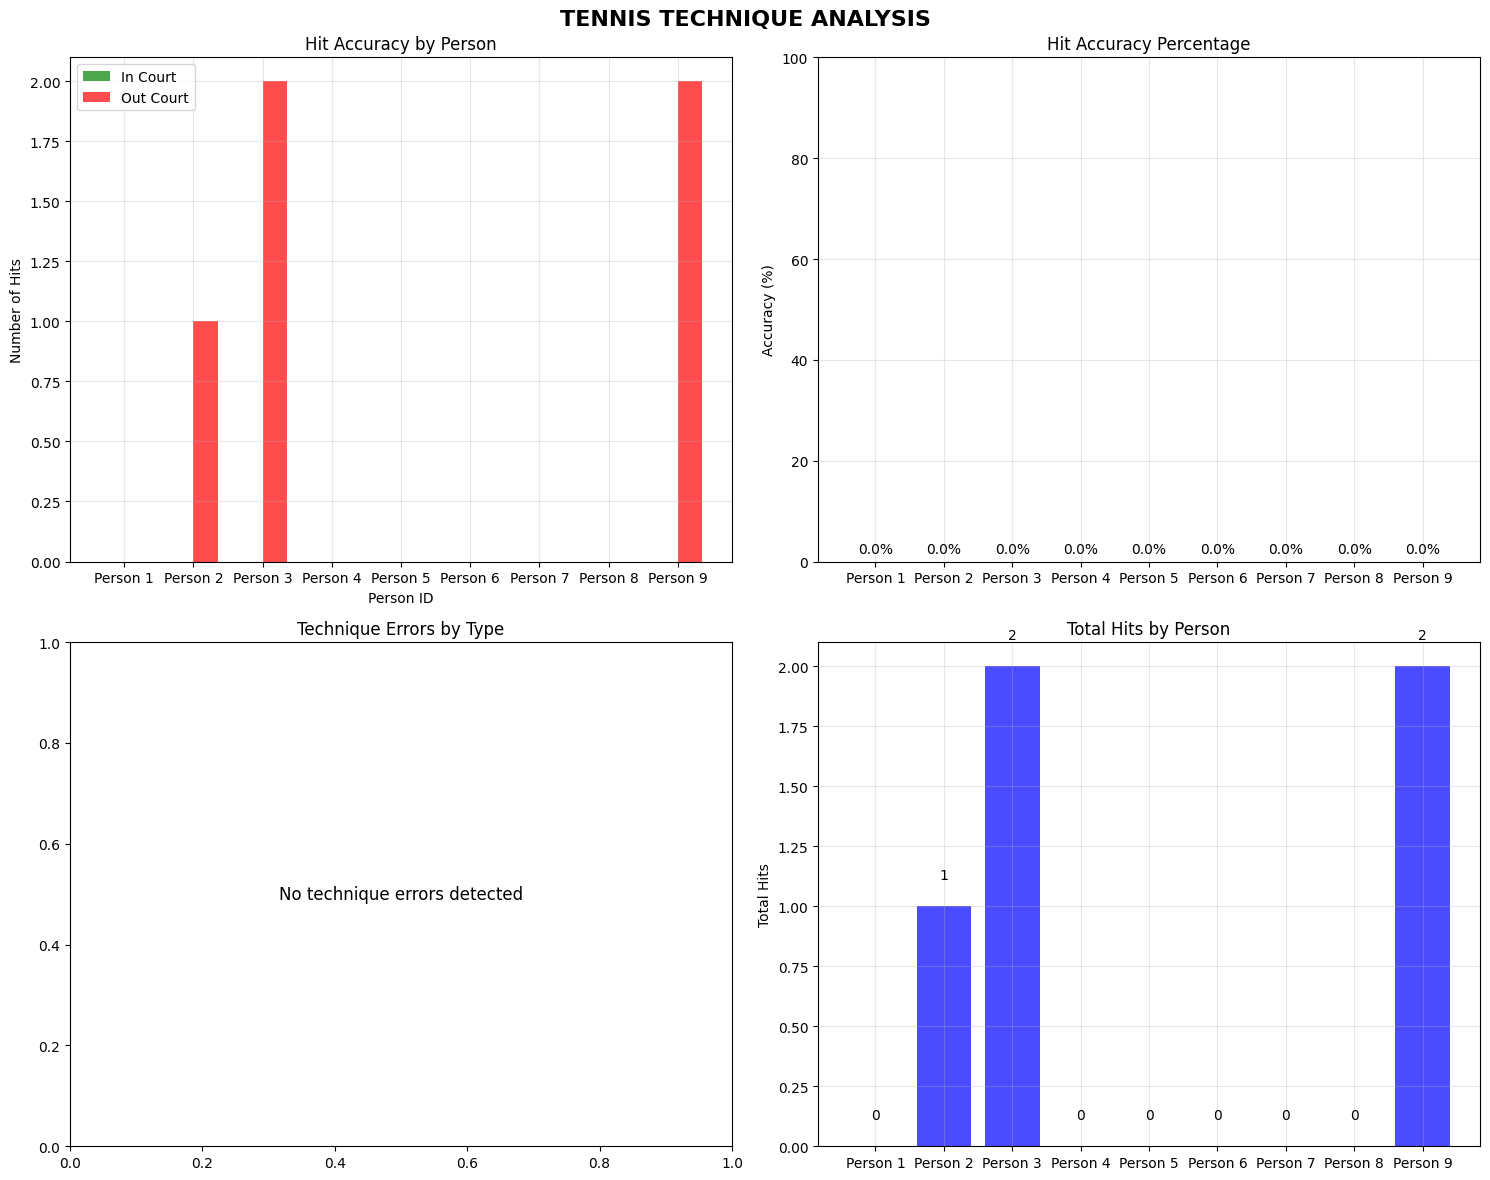

✅ Đã tạo biểu đồ: tennis_technique_analysis.png


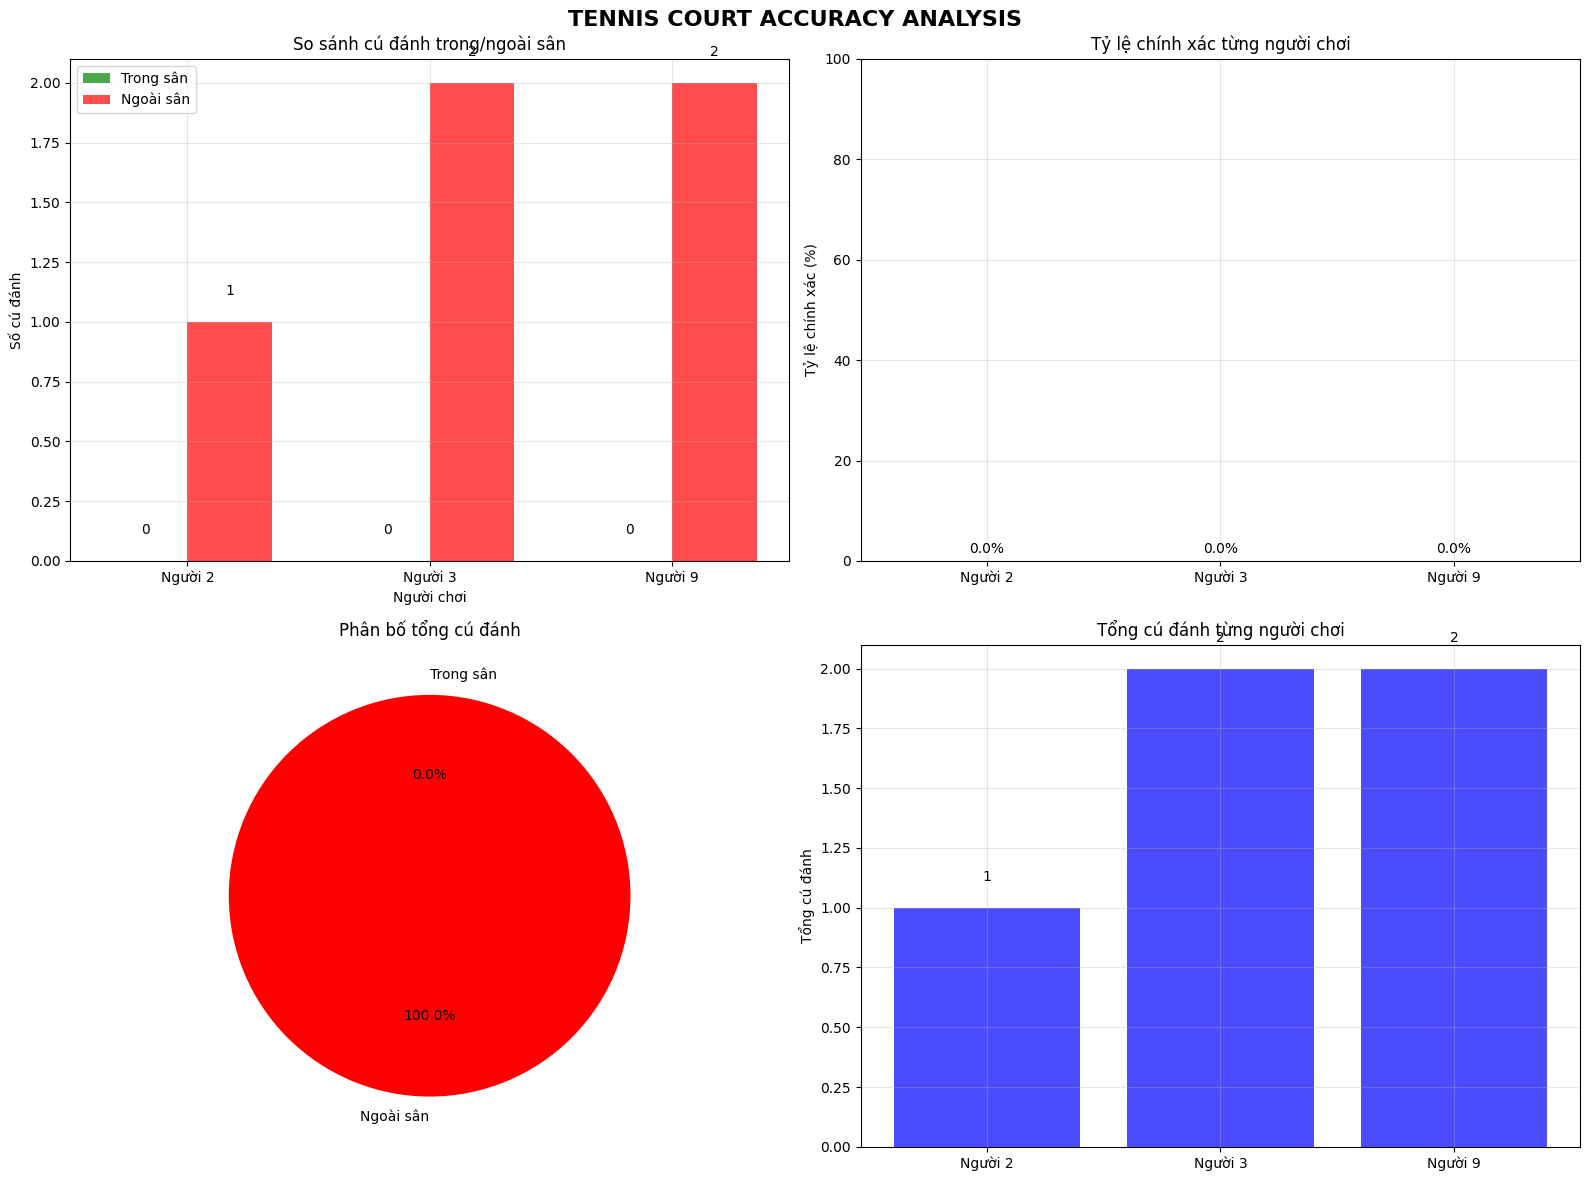

✅ Đã tạo biểu đồ độ chính xác: tennis_court_accuracy.png
✅ Đã tạo báo cáo chi tiết: tennis_detailed_report.txt

✅ HOÀN THÀNH PHÂN TÍCH!
📁 Các file đã tạo:
  - tennis_pose_analysis.mp4 (video với pose tracking)
  - tennis_technique_analysis.png (biểu đồ phân tích kỹ thuật)
  - tennis_court_accuracy.png (biểu đồ độ chính xác cú đánh)
  - tennis_detailed_report.txt (báo cáo chi tiết)

📊 TÓM TẮT KẾT QUẢ:
  - Số người được track: 9
  - Tổng cú đánh: 58
  - Cú đánh bởi người: 54
  - Cú đánh chạm đất: 4

🎯 THỐNG KÊ ĐỘ CHÍNH XÁC:
  - Tổng cú đánh: 5
  - Cú đánh trong sân: 0
  - Cú đánh ngoài sân: 5
  - Tỷ lệ chính xác tổng: 0.0%

👥 THỐNG KÊ TỪNG NGƯỜI CHƠI:
  Người 2: 0 trong sân, 1 ngoài sân (0.0%)
  Người 3: 0 trong sân, 2 ngoài sân (0.0%)
  Người 9: 0 trong sân, 2 ngoài sân (0.0%)

⚡ THỐNG KÊ VẬN TỐC:
  - Vận tốc bóng trung bình: 138.77 pixels/frame
  - Vận tốc bóng tối đa: 205.29 pixels/frame


In [ ]:
# =============================================================================
# DEMO CHẠY PHÂN TÍCH TENNIS VỚI PERSON TRACKING VÀ POSE ESTIMATION
# =============================================================================

# Cấu hình
ball_model_path = "ball_best.pt"
person_model_path = "yolov8m.pt"
pose_model_path = "yolov8m-pose.pt"  # Model pose estimation

print("🚀 BẮT ĐẦU PHÂN TÍCH TENNIS VỚI PERSON TRACKING & POSE ESTIMATION")
print("=" * 80)

# Chạy phân tích chính
results = analyze_tennis_with_person_tracking(
    video_path=video_path,
    ball_model_path=ball_model_path,
    person_model_path=person_model_path,
    pose_model_path=pose_model_path
)

# Lấy dữ liệu từ kết quả
person_tracker = results['person_tracker']
technique_analysis = results['technique_analysis']
person_stats = results['person_stats']
ball_positions = results['ball_positions']
direction_flags = results['direction_flags']
velocities = results['velocities']
frames = results['frames']

print("\n🎯 TẠO VISUALIZATION VÀ BÁO CÁO...")

# Tạo video visualization
create_pose_visualization(
    frames, 
    person_tracker.person_detections if hasattr(person_tracker, 'person_detections') else [],
    person_tracker.pose_detections if hasattr(person_tracker, 'pose_detections') else [],
    "tennis_pose_analysis.mp4"
)

# Tạo biểu đồ phân tích kỹ thuật
create_technique_analysis_plot(technique_analysis, "tennis_technique_analysis.png")

# Tạo biểu đồ độ chính xác cú đánh
create_court_accuracy_visualization(technique_analysis, "tennis_court_accuracy.png")

# Tạo báo cáo chi tiết
create_detailed_technique_report(person_tracker, technique_analysis, "tennis_detailed_report.txt")

print("\n✅ HOÀN THÀNH PHÂN TÍCH!")
print("📁 Các file đã tạo:")
print("  - tennis_pose_analysis.mp4 (video với pose tracking)")
print("  - tennis_technique_analysis.png (biểu đồ phân tích kỹ thuật)")
print("  - tennis_court_accuracy.png (biểu đồ độ chính xác cú đánh)")
print("  - tennis_detailed_report.txt (báo cáo chi tiết)")

print("\n📊 TÓM TẮT KẾT QUẢ:")
print(f"  - Số người được track: {len(person_tracker.tracked_persons)}")
print(f"  - Tổng cú đánh: {sum(1 for flag in direction_flags if flag > 0)}")
print(f"  - Cú đánh bởi người: {sum(1 for flag in direction_flags if flag == 2)}")
print(f"  - Cú đánh chạm đất: {sum(1 for flag in direction_flags if flag == 1)}")

# Hiển thị thống kê độ chính xác
court_accuracy = technique_analysis['court_accuracy']
print(f"\n🎯 THỐNG KÊ ĐỘ CHÍNH XÁC:")
print(f"  - Tổng cú đánh: {court_accuracy['total_hits']}")
print(f"  - Cú đánh trong sân: {court_accuracy['total_in_court']}")
print(f"  - Cú đánh ngoài sân: {court_accuracy['total_out_court']}")
print(f"  - Tỷ lệ chính xác tổng: {court_accuracy['overall_accuracy']:.1f}%")

# Hiển thị thống kê từng người (chỉ những người có cú đánh)
print(f"\n👥 THỐNG KÊ TỪNG NGƯỜI CHƠI:")
active_persons = {pid: stats for pid, stats in technique_analysis['person_stats'].items() if stats['total_hits'] > 0}
if active_persons:
    for person_id, stats in active_persons.items():
        print(f"  Người {person_id}: {stats['hits_in_court']} trong sân, {stats['hits_out_court']} ngoài sân ({stats['accuracy_percentage']:.1f}%)")
else:
    print("  ❌ Không có người chơi nào có cú đánh!")

if velocities:
    print(f"\n⚡ THỐNG KÊ VẬN TỐC:")
    print(f"  - Vận tốc bóng trung bình: {np.mean(velocities):.2f} pixels/frame")
    print(f"  - Vận tốc bóng tối đa: {np.max(velocities):.2f} pixels/frame")
